In [1]:
import numpy as np
import glob, os
from nilearn import image, plotting, masking
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.spatial import distance
from collections import Counter
from itertools import chain, compress
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import RidgeClassifier
from nilearn import image,plotting
import numpy as np
import pandas as pd
import glob, os, itertools
from brainiak.image import mask_images, multimask_images
from brainiak import io
from brainiak.fcma.preprocessing import prepare_mvpa_data
from brainiak.fcma.preprocessing import generate_epochs_info
from scipy.stats import pearsonr,ttest_1samp, rankdata, ttest_rel
from scipy.stats.mstats import zscore
from sklearn.svm import SVC
import seaborn as sns
import subprocess
import re 
from statsmodels.stats.anova import AnovaRM
from bioinfokit.analys import stat
%matplotlib inline
#["mPFC","rAG","Precuneus(Superior)","lAG1","PCC","MTG","lAG2","rITG","rLOC","rPFC","lPFC1","SFG","lPFC2",'lLOC',"Precuenus(Inferior)2","Precuneus(inferior)"]
#["mPFC", "r-IPL", "Precuneus", "l-IPL1", "PCC", "MTG", "l-IPL2", "r-ITG", "r-IPS", "r-PFC", "l-PFC1", "SFG", 'l-PFC2', "l-IPS", "RSC1", "RSC2"]

/packages/miniconda/20190102/envs/anaconda-tensorflow-gpu/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/peetal/.local/lib/python3.6/site-packages/nilearn/plotting/cm.py:159: MatplotlibDeprecationWarning: 
The revcmap function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use Colormap.reversed() instead.
  _cmaps_data[_cmapname_r] = _cm.revcmap(_cmapspec)
/packages/miniconda/20190102/envs/anaconda-tensorflow-gpu/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at 

In [24]:
acc_ret = [0.7637649, 0.8221726, 0.8985863, 0.8761161, 0.7957589, 0.7127976, 0.7444196, 0.8340774, 0.7396825,
           0.7399554, 0.8359375, 0.9218750, 0.8046875, 0.8225446, 0.8046875, 0.6629464, 0.8828125, 0.7734375,
           0.6997768, 0.6819196, 0.7671131, 0.7890625, 0.7343750, 0.9129464]

acc_scramble = [0.8991815, 0.8895089, 0.7589286, 0.8515625, 0.7388393, 0.7322917, 0.7912946, 0.8281250, 0.7235863, 0.8660714,
                0.8281250, 0.8270089, 0.7578125, 0.7444196, 0.8828125, 0.9218750, 0.8828125, 0.8593750, 0.7968750, 0.8203125,
                0.7957589, 0.8750000, 0.7797619, 0.8898810]

rt_ret = [1.2604852, 1.3749169, 1.4004185, 1.2224967, 1.2093293, 1.4865373, 1.2985464, 1.2808213, 1.4100159, 1.2577403, 1.0724749, 1.0723277,
 1.2405356, 1.5226281, 1.1920084, 1.2640316, 1.3238252, 1.1647616, 1.2708604, 0.9322277, 1.0304701, 1.3867451, 1.1605688, 1.0976606]

In [11]:
epoch_info[0]

(0, 0, 6, 30)

## Attention states (External: Perceive & Scramble; Internal: Retrieve)

In [61]:
def compute_ps(run1, run2):
    """
    run1 and run2 are two lists, each is a list of 4 epochs 
    """
    ps = []
    for epoch in run1:
        ps.append(np.mean([np.arctanh(pearsonr(epoch, y)[0]) for y in run2]))
    ps_mean = np.mean(ps)
    return(ps_mean)
        
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/allconds_epoch_labels_MVPA.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# get epoch identity (i.e., face/scene task under which condition )
epoch_condition = np.tile(np.repeat(['PerceiveScrambled', 'Retrieve', 'Perceive'],16),24)

epoch_dic = {}
for sub in range(num_subjs):
    epoch_start = epochs_per_subj*sub
    epoch = epoch_info[epoch_start: epoch_start + epochs_per_subj]
    sub_epoch_cond = epoch_condition[epoch_start: epoch_start + epochs_per_subj]
    for e, cond in zip(epoch, sub_epoch_cond):
        epoch_dic[e] = cond

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    #within_state_ps_persub = []
    #between_state_ps_persub = []

    for i in range(24):

        # get all 48 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]
        
        # identity for each block
        cond_identity = list(epoch_dic.values())[start_ind:end_ind]
        run_identity = [np.unique(cond_identity[start:start+8])[0] for start in list(np.arange(0,48,8))]

        # face epoch in 6 runs (each run has 4 face epochs)
        sub_epoch = {}
        for idx, cond in enumerate(run_identity):
            start = 8*idx
            if idx % 2 == 0:
                sub_epoch[f'{cond}_run1'] = sub_raw_data_list[start: start + 8]
            else: 
                sub_epoch[f'{cond}_run2'] = sub_raw_data_list[start: start + 8]
        
        within_state_ps_perROI.append(np.mean([compute_ps(sub_epoch['Retrieve_run1'],sub_epoch['Retrieve_run2']),
                                               compute_ps(sub_epoch['Perceive_run1'],sub_epoch['Perceive_run2']),
                                               compute_ps(sub_epoch['PerceiveScrambled_run1'],sub_epoch['PerceiveScrambled_run2']),
                                      np.mean([compute_ps(sub_epoch['Perceive_run1'],sub_epoch['PerceiveScrambled_run1']),
                                               compute_ps(sub_epoch['Perceive_run1'],sub_epoch['PerceiveScrambled_run2']),
                                               compute_ps(sub_epoch['Perceive_run2'],sub_epoch['PerceiveScrambled_run1']),
                                               compute_ps(sub_epoch['Perceive_run2'],sub_epoch['PerceiveScrambled_run2'])])
                                              ]))
                                               
        
        between_state_ps_perROI.append(np.mean([compute_ps(sub_epoch['Retrieve_run1'],sub_epoch['Perceive_run1']),
                                                compute_ps(sub_epoch['Retrieve_run1'],sub_epoch['Perceive_run2']),
                                                compute_ps(sub_epoch['Retrieve_run1'],sub_epoch['PerceiveScrambled_run1']),
                                                compute_ps(sub_epoch['Retrieve_run1'],sub_epoch['PerceiveScrambled_run2']),
                                                compute_ps(sub_epoch['Retrieve_run2'],sub_epoch['Perceive_run1']),
                                                compute_ps(sub_epoch['Retrieve_run2'],sub_epoch['Perceive_run2']),
                                                compute_ps(sub_epoch['Retrieve_run2'],sub_epoch['PerceiveScrambled_run1']),
                                                compute_ps(sub_epoch['Retrieve_run2'],sub_epoch['PerceiveScrambled_run2'])
                                               ]))

    # each ROI
    #within_state_ps_perROI.append(within_state_ps_persub)
    #between_state_ps_perROI.append(between_state_ps_persub)

In [62]:
# ----------------------------
# Write CSV and save the data
# ----------------------------
roi = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1","PCC",
       "Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
roi_other_name = ["mPFC", "r-IPL", "RSC1", "l-IPS", "r-IPS", "PCUN", "l-IPL1", "r-PFC", "l-PFC1", "PCC",
                  "RSC2", "SFG", 'l-PFC2', "MTG", "l-IPL2", "r-ITG"]
roi_type = ['DMN','DMN','RSC','CONT','CONT','DMN','DMN','CONT','CONT','DMN','RSC','CONT','CONT',
            'DMN','DMN','CONT']
df = pd.DataFrame(columns = ['sub_id','within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.tile(range(1,25),num_cluster).tolist() 
#df['within_state_ps'] = list(itertools.chain(*within_state_ps_perROI))
df['within_state_ps'] = within_state_ps_perROI
#df['between_state_ps'] = list(itertools.chain(*between_state_ps_perROI))
df['between_state_ps'] = between_state_ps_perROI
df['cluster'] = np.repeat(roi_other_name, 24)
df['cluster_type'] = np.repeat(roi_type, 24)
df['attention_index'] =  df['within_state_ps'] - df['between_state_ps']

df_attention = df.copy(deep = True)

                   df    sum_sq   mean_sq         F    PR(>F)
C(cluster_type)   2.0  0.002589  0.001295  0.338264  0.714183
Residual         69.0  0.264064  0.003827       NaN       NaN


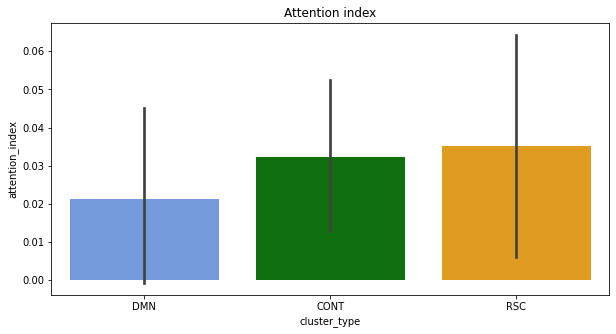

In [63]:
%matplotlib inline
ps_attention = df.groupby(['cluster_type', 'sub_id']).mean().reset_index()
#AnovaRM(data=ps_attention, depvar='attention_index', subject='sub_id', within=['cluster_type']).fit())


#from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=ps_attention, res_var='attention_index', anova_model='attention_index ~ C(cluster_type)')
print(res.anova_summary)
#res.tukey_summary

fig = plt.figure(figsize = (10, 5))
sns.barplot(x="cluster_type", y="attention_index", order = ['DMN', 'CONT', 'RSC'],
            palette=["cornflowerblue", "green", "orange"], data=ps_attention).set_title('Attention index')
plt.show()

In [65]:
df_attention.to_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/atten_actps.csv')

In [67]:
ps_attention = df_attention.groupby(['cluster_type', 'sub_id']).mean().reset_index()
ps_attention.groupby(['cluster_type']).apply(lambda ps_attention: ttest_1samp(ps_attention['attention_index'], 0))

cluster_type
CONT    (3.1673029822111918, 0.004301536297061454)
DMN      (1.8377536597320858, 0.07905177194208857)
RSC       (2.2619478018013055, 0.0334592970750262)
dtype: object

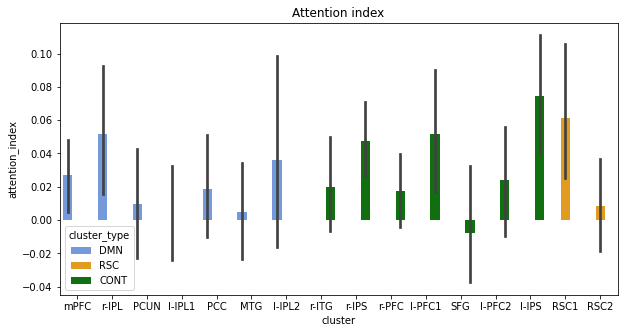

In [55]:
order = ["mPFC", "r-IPL", "PCUN", "l-IPL1", "PCC", "MTG", "l-IPL2", "r-ITG", "r-IPS", "r-PFC",
                  "l-PFC1", "SFG", 'l-PFC2', "l-IPS", "RSC1", "RSC2"]

fig = plt.figure(figsize = (10, 5))
sns.barplot(x="cluster", y="attention_index", hue='cluster_type', order = order, palette=["cornflowerblue", "orange", "green"], data=df).set_title('Attention index')
plt.show()

In [43]:
# cutoff = 0.05/16 = 0.003 (too harsh)
tstats_table = df.groupby(['cluster']).apply(lambda df: ttest_1samp(df['attention_index'], 0)[0]).reset_index(name='t-stats').reindex([11, 12, 2, 6, 1, 0, 7, 14, 13, 15, 9, 5, 10, 8, 3, 4])
pvalue_table = df.groupby(['cluster']).apply(lambda df: ttest_1samp(df['attention_index'], 0)[1]).reset_index(name='p-value').reindex([11, 12, 2, 6, 1, 0, 7, 14, 13, 15, 9, 5, 10, 8, 3, 4])
tstats_table.merge(pvalue_table, on = 'cluster', how = 'inner')

,cluster,t-stats,p-value
0,mPFC,2.046424,0.052311
1,r-IPL,0.618681,0.542206
2,PCUN,2.203354,0.037854
3,l-IPL1,0.991856,0.331588
4,PCC,1.011504,0.322299
5,MTG,2.397623,0.025014
6,l-IPL2,0.673825,0.507138
7,r-ITG,-0.189809,0.851124
8,r-IPS,-2.007496,0.056587
9,r-PFC,-0.913628,0.370391


In [25]:
for cluster in ["mPFC", "r-IPL", "PCUN", "l-IPL1", "PCC", "MTG", "l-IPL2", "r-ITG", "r-IPS", "r-PFC",
                "l-PFC1", "SFG", 'l-PFC2', "l-IPS", "RSC1", "RSC2"]:
    print(cluster)
    print(pearsonr(df.loc[df['cluster'] == cluster, 'attention_index'].tolist(), 
                                acc_ret))
    print(pearsonr(df.loc[df['cluster'] == cluster, 'attention_index'].tolist(), 
                                acc_scramble))

mPFC
(0.07705971640871405, 0.7204228285218974)
(-0.1353100627795957, 0.5284303320816142)
r-IPL
(-0.15663198002079104, 0.464838053488115)
(0.2313815559119933, 0.27665308130709576)
PCUN
(0.1855862869265855, 0.3852706009084242)
(0.01183039981031559, 0.9562463011461709)
l-IPL1
(-0.08896765759284692, 0.6793099977288557)
(0.13976138490290171, 0.5148232883410313)
PCC
(0.12452639805420497, 0.5620834711269868)
(0.1214740857112791, 0.5717804770840716)
MTG
(0.026850336079869537, 0.9008883359463983)
(0.18001388055724174, 0.39994812904307325)
l-IPL2
(0.05930488608011565, 0.7831120408069038)
(0.43743069440326265, 0.032548762272188864)
r-ITG
(0.1754396238323835, 0.4122265424273611)
(-0.13382706783654116, 0.5330011212190773)
r-IPS
(0.05438986689077106, 0.8007187178821242)
(0.09482765575846137, 0.6593907880327057)
r-PFC
(-0.12053118920760762, 0.5747908741514614)
(0.21413376358736652, 0.31501612402326606)
l-PFC1
(0.15109529205805647, 0.4809597241145465)
(0.35332555728344406, 0.09033002027332054)
SFG
(-0

## Task index (External: Perceive & Scramble; Internal: Retrieve)

In [12]:
def compute_ps(run1, run2):
    """
    run1 and run2 are two lists, each is a list of 4 epochs 
    """
    ps = []
    for epoch in run1:
        ps.append(np.mean([np.arctanh(pearsonr(epoch, y)[0]) for y in run2]))
    ps_mean = np.mean(ps)
    return(ps_mean)
        
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceTask_sceneTask_epoch_lables_48epochs.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# get epoch identity (i.e., face/scene task under which condition )
epoch_identity = pd.read_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/epoch_and_labels/block_image_identity.csv')
faceTask_cond = epoch_identity.loc[epoch_identity['block'] == 'Face', 'condition'].tolist()
sceneTask_cond = epoch_identity.loc[epoch_identity['block'] == 'Scene', 'condition'].tolist()
epoch_dic = {}
for sub in range(num_subjs):
    epoch_start = epochs_per_subj*sub
    epoch_cond_start = int(epochs_per_subj/2*sub)
    epoch = epoch_info[epoch_start: epoch_start + epochs_per_subj]
    sub_faceTask_cond = faceTask_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    sub_sceneTask_cond = sceneTask_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    for e, cond in zip(epoch, sub_faceTask_cond + sub_sceneTask_cond):
        epoch_dic[e] = cond

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    #within_state_ps_persub = []
    #between_state_ps_persub = []

    for i in range(24):

        # get all 48 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]
        
        # identity for each block
        cond_identity = list(epoch_dic.values())[start_ind:end_ind]
        face_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(0,24,4))]
        scene_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(24,48,4))]
        
        # face epoch in 6 runs (each run has 4 face epochs)
        face = {}
        for idx, cond in enumerate(face_runs):
            start = 4*idx
            if idx < 3:
                face[f'{cond}_run1_face'] = sub_raw_data_list[start:start+4]
            else:
                face[f'{cond}_run2_face'] = sub_raw_data_list[start:start+4]
        
        # scene epoch in 6 runs (each run has 4 scene epochs)
        scene = {}
        for idx, cond in enumerate(scene_runs):
            start = 24 + 4*idx
            if idx < 3:
                scene[f'{cond}_run1_scene'] = sub_raw_data_list[start:start+4]
            else:
                scene[f'{cond}_run2_scene'] = sub_raw_data_list[start:start+4]
         
        # each subject
        within_state_ps_perROI.append(np.mean([np.mean([compute_ps(face['Perceive_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['Retrieve_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['Retrieve_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['PerceiveScrambled_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['PerceiveScrambled_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run2_scene'])]),
                                       np.mean([compute_ps(face['Perceive_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run2_scene'])])]))
        # compute between- state PS
        between_state_ps_perROI.append(np.mean([np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run2_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run2_face']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['PerceiveScrambled_run2_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(face['Retrieve_run1_face'], scene['Retrieve_run2_scene'])]),
                                                np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['Perceive_run2_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['Perceive_run2_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run2_face'])])]))
    # each ROI
    #within_state_ps_perROI.append(within_state_ps_persub)
    #between_state_ps_perROI.append(between_state_ps_persub)


# ----------------------------
# Write CSV and save the data
# ----------------------------
roi = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1",
       "PCC","Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
roi_other_name = ["mPFC", "r-IPL", "RSC1", "l-IPS", "r-IPS", "PCUN", "l-IPL1", "r-PFC", "l-PFC1", "PCC",
                  "RSC2", "SFG", 'l-PFC2', "MTG", "l-IPL2", "r-ITG"]
roi_type = ['DMN','DMN','RSC','CONT','CONT','DMN','DMN','CONT','CONT','DMN','RSC','CONT','CONT',
            'DMN','DMN','CONT']
df = pd.DataFrame(columns = ['sub_id','within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.tile(range(1,25),num_cluster).tolist() 
#df['within_state_ps'] = list(itertools.chain(*within_state_ps_perROI))
df['within_state_ps'] = within_state_ps_perROI
#df['between_state_ps'] = list(itertools.chain(*between_state_ps_perROI))
df['between_state_ps'] = between_state_ps_perROI
df['cluster'] = np.repeat(roi_other_name, 24)
df['cluster_type'] = np.repeat(roi_type, 24)
df['task_index'] =  df['within_state_ps'] - df['between_state_ps']
#ps_task = df.groupby(['cluster_type', 'sub_id']).mean().reset_index()

df.to_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/task_actps.csv')


In [13]:
df.to_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/task_actps.csv')

In [ ]:

# ANOVA
ps_task = df.groupby(['cluster_type', 'sub_id']).mean().reset_index()
res = stat()
res.anova_stat(df=ps_task, res_var='task_index', anova_model='task_index ~ C(cluster_type)')
print(res.anova_summary)

# Post-hoc
res = stat()
res.tukey_hsd(df=ps_task, res_var='task_index', xfac_var='cluster_type', anova_model='task_index ~ C(cluster_type)')
print(res.tukey_summary)

#ps_task['cluster_type'] = ps_task['cluster_type'].astype("category")

sns.barplot(x="cluster_type", y="task_index", order = ['DMN', 'CONT', 'RSC'],
            palette=["cornflowerblue", "green", "orange"], data=ps_task)
plt.show()

In [6]:
ps_task.to_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/task_actps.csv')

In [46]:
ps_task.groupby(['cluster_type']).apply(lambda ps_task: ttest_1samp(ps_task['task_index'], 0))

cluster_type
CONT     (7.039913457270525, 3.5745361209812865e-07)
DMN      (7.319712037379507, 1.9027978465493868e-07)
RSC     (7.5031038587877354, 1.2657219203367754e-07)
dtype: object

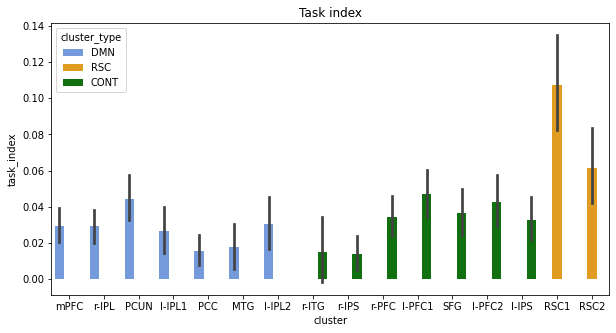

In [47]:
order = ["mPFC", "r-IPL", "PCUN", "l-IPL1", "PCC", "MTG", "l-IPL2", "r-ITG", "r-IPS", "r-PFC",
                  "l-PFC1", "SFG", 'l-PFC2', "l-IPS", "RSC1", "RSC2"]

fig = plt.figure(figsize = (10, 5))
sns.barplot(x="cluster", y="task_index", hue='cluster_type', order = order, 
            palette=["cornflowerblue", "orange", "green"], data=df).set_title('Task index')
plt.show()

In [48]:
# cutoff = 0.05/16 = 0.003 (too harsh)
tstats_table = df.groupby(['cluster']).apply(lambda df: ttest_1samp(df['task_index'], 0)[0]).reset_index(name='t-stats').reindex([11, 12, 2, 6, 1, 0, 7, 14, 13, 15, 9, 5, 10, 8, 3, 4])
pvalue_table = df.groupby(['cluster']).apply(lambda df: ttest_1samp(df['task_index'], 0)[1]).reset_index(name='p-value').reindex([11, 12, 2, 6, 1, 0, 7, 14, 13, 15, 9, 5, 10, 8, 3, 4])
tstats_table.merge(pvalue_table, on = 'cluster', how = 'left')

,cluster,t-stats,p-value
0,mPFC,5.984422,4.211222e-06
1,r-IPL,6.231539,2.336129e-06
2,PCUN,6.234818,2.318039e-06
3,l-IPL1,3.734323,1.085571e-03
4,PCC,3.674162,1.258796e-03
5,MTG,2.900111,8.069648e-03
6,l-IPL2,4.026090,5.272413e-04
7,r-ITG,1.577527,1.283303e-01
8,r-IPS,2.935320,7.434590e-03
9,r-PFC,6.057930,3.531676e-06


In [36]:
# network ~ behavioral
print(pearsonr(ps_task.loc[ps_task['cluster_type'] == 'CONT', 'task_index'].tolist(), 
                                acc_ret))
print(pearsonr(ps_task.loc[ps_task['cluster_type'] == 'DMN', 'task_index'].tolist(), 
                                acc_ret))
print(pearsonr(ps_task.loc[ps_task['cluster_type'] == 'RSC', 'task_index'].tolist(), 
                                acc_ret))
print(pearsonr(ps_task.loc[ps_task['cluster_type'] == 'CONT', 'task_index'].tolist(), 
                                acc_scramble))
print(pearsonr(ps_task.loc[ps_task['cluster_type'] == 'DMN', 'task_index'].tolist(), 
                                acc_scramble))
print(pearsonr(ps_task.loc[ps_task['cluster_type'] == 'RSC', 'task_index'].tolist(), 
                                acc_scramble))

(0.2603006623390031, 0.21927993943430935)
(0.20334163202774533, 0.34059271467633107)
(-0.08402812971910682, 0.6962643070138896)
(0.08981491065001303, 0.6764167351858225)
(0.046208495807577334, 0.8302321176620211)
(-0.04255767668898486, 0.8434767578350744)


In [81]:
for cluster in ["mPFC", "r-IPL", "PCUN", "l-IPL1", "PCC", "MTG", "l-IPL2", "r-ITG", "r-IPS", "r-PFC",
                "l-PFC1", "SFG", 'l-PFC2', "l-IPS", "RSC1", "RSC2"]:
    print(cluster)
    print(pearsonr(df.loc[df['cluster'] == cluster, 'task_index'].tolist(), 
                                acc_ret))
    print(pearsonr(df.loc[df['cluster'] == cluster, 'task_index'].tolist(), 
                                acc_scramble))

mPFC
(0.31890421186481877, 0.12879244630211237)
(0.07891556769847075, 0.7139623418959701)
r-IPL
(0.016094874592582603, 0.9404981287284467)
(0.03863143624539278, 0.857766575336337)
PCUN
(0.2678344728307285, 0.2057491651760045)
(0.1677107780104174, 0.43343724610289014)
l-IPL1
(0.13523098417236257, 0.5286735934771609)
(-0.04130014660764808, 0.8480486291500962)
PCC
(0.26084917947032416, 0.2182752390795674)
(-0.026355603937175204, 0.9027059986831971)
MTG
(-0.0066606898140542286, 0.9753581721004282)
(0.07115337623703302, 0.7411055996328674)
l-IPL2
(-0.02559995139924133, 0.9054832045238329)
(-0.07490546116573805, 0.7279454214780049)
r-ITG
(0.036641294943388164, 0.8650267040700605)
(0.3092807679514689, 0.14139618627283834)
r-IPS
(0.004342677494891256, 0.9839325036399948)
(-0.31647799491161366, 0.13189055365261393)
r-PFC
(0.2847289644697418, 0.17748875451021806)
(0.08288973525820004, 0.7001921501031991)
l-PFC1
(0.4319032351002322, 0.035068420515138046)
(-0.03725631084129921, 0.8627819382496692)

## Visual State (no Scramble condition)

                   df    sum_sq   mean_sq          F        PR(>F)
C(cluster_type)   2.0  0.218423  0.109211  37.828705  8.101025e-12
Residual         69.0  0.199203  0.002887        NaN           NaN
  group1 group2      Diff     Lower     Upper    q-value  p-value
0   CONT    DMN  0.074537  0.037384  0.111690   6.795989    0.001
1   CONT    RSC  0.060121  0.022968  0.097274   5.481590    0.001
2    DMN    RSC  0.134657  0.097504  0.171811  12.277579    0.001


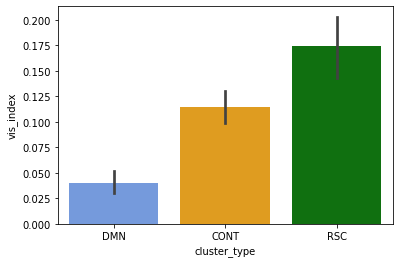

In [5]:
def compute_ps(run1, run2):
    """
    run1 and run2 are two lists, each is a list of 4 epochs 
    """
    ps = []
    for epoch in run1:
        ps.append(np.mean([np.arctanh(pearsonr(epoch, y)[0]) for y in run2]))
    ps_mean = np.mean(ps)
    return(ps_mean)
        
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceCue_sceneCue_epoch_lables.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# get epoch identity (i.e., face/scene task under which condition )
epoch_identity = pd.read_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/epoch_and_labels/block_image_identity.csv')
epoch_identity_noscramble = epoch_identity[epoch_identity['condition'] != 'PerceiveScrambled']
faceCue_cond = epoch_identity_noscramble.loc[epoch_identity_noscramble['block'] == 'Face', 'condition'].tolist()
sceneCue_cond = epoch_identity_noscramble.loc[epoch_identity_noscramble['block'] == 'Scene', 'condition'].tolist()

epoch_dic = {}
for sub in range(num_subjs):
    epoch_start = epochs_per_subj*sub
    epoch_cond_start = int(epochs_per_subj/2*sub)
    epoch = epoch_info[epoch_start: epoch_start + epochs_per_subj]
    sub_faceCue_cond = faceCue_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    sub_sceneCue_cond = sceneCue_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    for e, cond in zip(epoch, sub_faceCue_cond + sub_sceneCue_cond):
        epoch_dic[e] = cond

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    #within_state_ps_persub = []
    #between_state_ps_persub = []

    for i in range(24):

        # get all 32 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]
        
        # identity for each block
        cond_identity = list(epoch_dic.values())[start_ind:end_ind]
        face_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(0,16,4))]
        scene_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(16,32,4))]
        
        # face epoch in 6 runs (each run has 4 face epochs)
        face = {}
        for idx, cond in enumerate(face_runs):
            start = 4*idx
            if idx < 2:
                face[f'{cond}_run1_face'] = sub_raw_data_list[start:start+4]
            else:
                face[f'{cond}_run2_face'] = sub_raw_data_list[start:start+4]
        
        # scene epoch in 6 runs (each run has 4 scene epochs)
        scene = {}
        for idx, cond in enumerate(scene_runs):
            start = 16 + 4*idx
            if idx < 2:
                scene[f'{cond}_run1_scene'] = sub_raw_data_list[start:start+4]
            else:
                scene[f'{cond}_run2_scene'] = sub_raw_data_list[start:start+4]
         
        # each subject   
        within_state_ps_perROI.append(np.mean([np.mean([compute_ps(face['Perceive_run1_face'], face['Perceive_run2_face']),
                                                        compute_ps(face['Retrieve_run1_face'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['Perceive_run1_scene'], scene['Perceive_run2_scene']),
                                                        compute_ps(scene['Retrieve_run1_scene'], scene['Retrieve_run2_scene'])]),
                                               np.mean([compute_ps(face['Perceive_run1_face'], face['Retrieve_run1_face']),
                                                        compute_ps(face['Perceive_run1_face'], face['Retrieve_run2_face']),
                                                        compute_ps(face['Perceive_run2_face'], face['Retrieve_run1_face']),
                                                        compute_ps(face['Perceive_run2_face'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run1_scene']),
                                                        compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run2_scene']),
                                                        compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run1_scene']),
                                                        compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run2_scene'])])]))
        # compute between- state PS
        between_state_ps_perROI.append(np.mean([np.mean([compute_ps(face['Perceive_run1_face'], scene['Perceive_run2_scene']),
                                                         compute_ps(scene['Perceive_run1_scene'], face['Perceive_run2_face']),
                                                         compute_ps(face['Retrieve_run1_face'], scene['Retrieve_run2_scene']),
                                                         compute_ps(scene['Retrieve_run1_scene'], face['Retrieve_run2_face'])]),
                                                np.mean([compute_ps(face['Perceive_run1_face'], scene['Retrieve_run1_scene']),
                                                         compute_ps(face['Perceive_run1_face'], scene['Retrieve_run2_scene']),
                                                         compute_ps(face['Perceive_run2_face'], scene['Retrieve_run1_scene']),
                                                         compute_ps(face['Perceive_run2_face'], scene['Retrieve_run2_scene']),
                                                         compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run1_face']),
                                                         compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run2_face']),
                                                         compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run1_face']),
                                                         compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run2_face'])])]))
    # each ROI
    #within_state_ps_perROI.append(within_state_ps_persub)
    #between_state_ps_perROI.append(between_state_ps_persub)

# ----------------------------
# Write CSV and save the data
# ----------------------------
roi = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1",
       "PCC","Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
roi_other_name = ["mPFC", "r-IPL", "RSC1", "l-IPS", "r-IPS", "PCUN", "l-IPL1", "r-PFC", "l-PFC1", "PCC",
                  "RSC2", "SFG", 'l-PFC2', "MTG", "l-IPL2", "r-ITG"]
roi_type = ['DMN','DMN','RSC','CONT','CONT','DMN','DMN','CONT','CONT','DMN','RSC','CONT','CONT',
            'DMN','DMN','CONT']
df = pd.DataFrame(columns = ['sub_id','within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.tile(range(1,25),num_cluster).tolist() 
#df['within_state_ps'] = list(itertools.chain(*within_state_ps_perROI))
df['within_state_ps'] = within_state_ps_perROI
#df['between_state_ps'] = list(itertools.chain(*between_state_ps_perROI))
df['between_state_ps'] = between_state_ps_perROI
df['cluster'] = np.repeat(roi_other_name, 24)
df['cluster_type'] = np.repeat(roi_type, 24)
df['vis_index'] =  df['within_state_ps'] - df['between_state_ps']
ps_vis = df.groupby(['cluster_type', 'sub_id']).mean().reset_index()

# ANOVA
ps_vis = df.groupby(['cluster_type', 'sub_id']).mean().reset_index()
res = stat()
res.anova_stat(df=ps_vis, res_var='vis_index', anova_model='vis_index ~ C(cluster_type)')
print(res.anova_summary)

# Post-hoc
res = stat()
res.tukey_hsd(df=ps_vis, res_var='vis_index', xfac_var='cluster_type', anova_model='vis_index ~ C(cluster_type)')
print(res.tukey_summary)

#ps_task['cluster_type'] = ps_task['cluster_type'].astype("category")

sns.barplot(x="cluster_type", y="vis_index", order = ['DMN', 'CONT', 'RSC'], 
            palette=["cornflowerblue", "orange", "green"], data=ps_vis)
plt.show()

In [6]:
#df.to_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/vis_actps.csv')

32.0

In [37]:
ps_vis.groupby(['cluster_type']).apply(lambda ps_vis: ttest_1samp(ps_vis['vis_index'], 0))

cluster_type
CONT    (4.745204882694028, 8.784999003476935e-05)
DMN     (4.99188001801814, 4.7591817351403484e-05)
RSC     (4.163030304859805, 0.0003750268331568932)
dtype: object

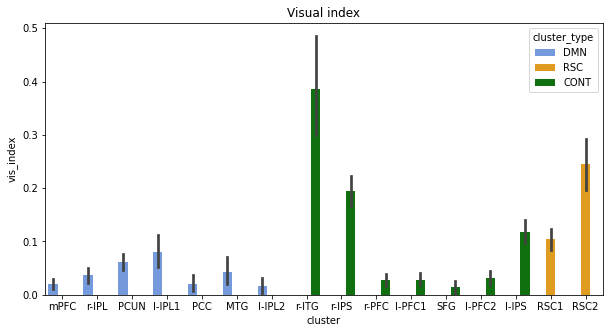

In [32]:
order = ["mPFC", "r-IPL", "PCUN", "l-IPL1", "PCC", "MTG", "l-IPL2", "r-ITG", "r-IPS", "r-PFC",
                  "l-PFC1", "SFG", 'l-PFC2', "l-IPS", "RSC1", "RSC2"]

fig = plt.figure(figsize = (10, 5))
sns.barplot(x="cluster", y="vis_index", hue='cluster_type', order = order, 
            palette=["cornflowerblue", "orange", "green"], data=df).set_title('Visual index')
plt.show()

In [52]:
# cutoff = 0.05/16 = 0.003 (too harsh)
tstats_table = df.groupby(['cluster']).apply(lambda df: ttest_1samp(df['vis_index'], 0)[0]).reset_index(name='t-stats').reindex([11, 12, 2, 6, 1, 0, 7, 14, 13, 15, 9, 5, 10, 8, 3, 4])
pvalue_table = df.groupby(['cluster']).apply(lambda df: ttest_1samp(df['vis_index'], 0)[1]).reset_index(name='p-value').reindex([11, 12, 2, 6, 1, 0, 7, 14, 13, 15, 9, 5, 10, 8, 3, 4])
tstats_table.merge(pvalue_table, on = 'cluster', how = 'left')

,cluster,t-stats,p-value
0,mPFC,4.192563,3.484307e-04
1,r-IPL,4.892357,6.092599e-05
2,PCUN,7.413163,1.545003e-07
3,l-IPL1,5.241709,2.566268e-05
4,PCC,2.728344,1.198151e-02
5,MTG,3.187860,4.095713e-03
6,l-IPL2,2.143631,4.286612e-02
7,r-ITG,7.822872,6.284371e-08
8,r-IPS,13.150623,3.480736e-12
9,r-PFC,4.573576,1.347336e-04


In [35]:
# network ~ behavioral
print(pearsonr(ps_vis.loc[ps_vis['cluster_type'] == 'CONT', 'vis_index'].tolist(), 
                                acc_ret))
print(pearsonr(ps_vis.loc[ps_vis['cluster_type'] == 'DMN', 'vis_index'].tolist(), 
                                acc_ret))
print(pearsonr(ps_vis.loc[ps_vis['cluster_type'] == 'RSC', 'vis_index'].tolist(), 
                                acc_ret))
print(pearsonr(ps_vis.loc[ps_vis['cluster_type'] == 'CONT', 'vis_index'].tolist(), 
                                acc_scramble))
print(pearsonr(ps_vis.loc[ps_vis['cluster_type'] == 'DMN', 'vis_index'].tolist(), 
                                acc_scramble))
print(pearsonr(ps_vis.loc[ps_vis['cluster_type'] == 'RSC', 'vis_index'].tolist(), 
                                acc_scramble))

(0.19809032753996786, 0.3534721493482859)
(0.031049061944242902, 0.8854824073551163)
(-0.06871280904052177, 0.7497039443222088)
(0.12894540794704457, 0.5481770551152169)
(-0.05353775839326335, 0.8037810131910704)
(0.15940052104819588, 0.4568828554106517)


In [34]:
for cluster in ["mPFC", "r-IPL", "PCUN", "l-IPL1", "PCC", "MTG", "l-IPL2", "r-ITG", "r-IPS", "r-PFC",
                "l-PFC1", "SFG", 'l-PFC2', "l-IPS", "RSC1", "RSC2"]:
    print(cluster)
    print(pearsonr(df.loc[df['cluster'] == cluster, 'vis_index'].tolist(), 
                                acc_ret))
    print(pearsonr(df.loc[df['cluster'] == cluster, 'vis_index'].tolist(), 
                                acc_scramble))

mPFC
(-0.3283631721905789, 0.11721536403367398)
(-0.13668593342654342, 0.5242063873730121)
r-IPL
(0.12623018566372846, 0.5567029977568463)
(-0.24133510871257052, 0.2559259928139081)
PCUN
(0.1430080157487573, 0.5050068243832179)
(0.13210771938073312, 0.5383235457698599)
l-IPL1
(-0.10074527217618302, 0.6395011778265658)
(0.12601613416690338, 0.5573776770617046)
PCC
(0.31192341521604605, 0.13785076463103071)
(-0.09966032314679474, 0.6431302930007701)
MTG
(-0.023703220676327418, 0.9124588164270909)
(-0.009811016380274745, 0.9637095292030121)
l-IPL2
(0.020373977716796266, 0.9247176617201033)
(-0.2309782585367394, 0.27751468146604497)
r-ITG
(0.2650383547477001, 0.21070350882162786)
(0.16498000823247194, 0.4410691869286807)
r-IPS
(0.20488770364615316, 0.3368547876321505)
(0.20632177949791014, 0.33340965614233387)
r-PFC
(0.10678877587432842, 0.6194343223174581)
(0.03353735785851615, 0.8763709814308175)
l-PFC1
(-0.3823035861603419, 0.06523190107430875)
(-0.14628079919266945, 0.49520502824729823

                   df    sum_sq   mean_sq          F        PR(>F)
C(cluster_type)   2.0  0.274947  0.137474  39.073036  4.497429e-12
Residual         69.0  0.242768  0.003518        NaN           NaN
  group1 group2      Diff     Lower     Upper    q-value  p-value
0   CONT    DMN  0.064990  0.023975  0.106005   5.367609    0.001
1   CONT    RSC  0.085896  0.044881  0.126911   7.094267    0.001
2    DMN    RSC  0.150886  0.109871  0.191901  12.461876    0.001


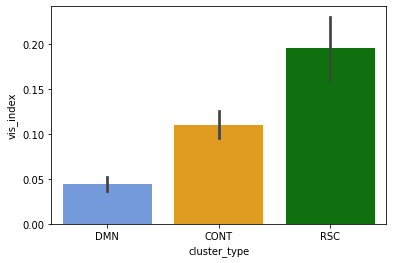

In [6]:
def compute_ps(run1, run2):
    """
    run1 and run2 are two lists, each is a list of 4 epochs 
    """
    ps = []
    for epoch in run1:
        ps.append(np.mean([np.arctanh(pearsonr(epoch, y)[0]) for y in run2]))
    ps_mean = np.mean(ps)
    return(ps_mean)
        
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceCue_sceneCue_epoch_lables_48epochs.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# get epoch identity (i.e., face/scene task under which condition )
epoch_identity = pd.read_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/epoch_and_labels/block_image_identity.csv')
#epoch_identity_noscramble = epoch_identity[epoch_identity['condition'] != 'PerceiveScrambled']
#faceCue_cond = epoch_identity_noscramble.loc[epoch_identity_noscramble['block'] == 'Face', 'condition'].tolist()
#sceneCue_cond = epoch_identity_noscramble.loc[epoch_identity_noscramble['block'] == 'Scene', 'condition'].tolist()

faceCue_cond = epoch_identity.loc[epoch_identity['block'] == 'Face', 'condition'].tolist()
sceneCue_cond = epoch_identity.loc[epoch_identity['block'] == 'Scene', 'condition'].tolist()

epoch_dic = {}
for sub in range(num_subjs):
    epoch_start = epochs_per_subj*sub
    epoch_cond_start = int(epochs_per_subj/2*sub)
    epoch = epoch_info[epoch_start: epoch_start + epochs_per_subj]
    sub_faceCue_cond = faceCue_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    sub_sceneCue_cond = sceneCue_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    for e, cond in zip(epoch, sub_faceCue_cond + sub_sceneCue_cond):
        epoch_dic[e] = cond

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    #within_state_ps_persub = []
    #between_state_ps_persub = []

    for i in range(24):

        # get all 32 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]
        
        # identity for each block
        cond_identity = list(epoch_dic.values())[start_ind:end_ind]
        face_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(0,24,4))]
        scene_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(24,48,4))]
        
        # face epoch in 6 runs (each run has 4 face epochs)
        face = {}
        for idx, cond in enumerate(face_runs):
            start = 4*idx
            if idx < 3:
                face[f'{cond}_run1_face'] = sub_raw_data_list[start:start+4]
            else:
                face[f'{cond}_run2_face'] = sub_raw_data_list[start:start+4]
        
        # scene epoch in 6 runs (each run has 4 scene epochs)
        scene = {}
        for idx, cond in enumerate(scene_runs):
            start = 24 + 4*idx
            if idx < 3:
                scene[f'{cond}_run1_scene'] = sub_raw_data_list[start:start+4]
            else:
                scene[f'{cond}_run2_scene'] = sub_raw_data_list[start:start+4]
         
        # each subject   
        within_state_ps_perROI.append(np.mean([np.mean([compute_ps(face['Perceive_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['Retrieve_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['Retrieve_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['PerceiveScrambled_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['PerceiveScrambled_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run2_scene'])]),
                                       np.mean([compute_ps(face['Perceive_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run2_scene'])])]))
        # compute between- state PS
        between_state_ps_perROI.append(np.mean([np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run2_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run2_face']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['PerceiveScrambled_run2_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(face['Retrieve_run1_face'], scene['Retrieve_run2_scene'])]),
                                                np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['Perceive_run2_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['Perceive_run2_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run2_face'])])]))
    # each ROI
    #within_state_ps_perROI.append(within_state_ps_persub)
    #between_state_ps_perROI.append(between_state_ps_persub)

# ----------------------------
# Write CSV and save the data
# ----------------------------
roi = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1",
       "PCC","Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
roi_other_name = ["mPFC", "r-IPL", "RSC1", "l-IPS", "r-IPS", "PCUN", "l-IPL1", "r-PFC", "l-PFC1", "PCC",
                  "RSC2", "SFG", 'l-PFC2', "MTG", "l-IPL2", "r-ITG"]
roi_type = ['DMN','DMN','RSC','CONT','CONT','DMN','DMN','CONT','CONT','DMN','RSC','CONT','CONT',
            'DMN','DMN','CONT']
df = pd.DataFrame(columns = ['sub_id','within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.tile(range(1,25),num_cluster).tolist() 
#df['within_state_ps'] = list(itertools.chain(*within_state_ps_perROI))
df['within_state_ps'] = within_state_ps_perROI
#df['between_state_ps'] = list(itertools.chain(*between_state_ps_perROI))
df['between_state_ps'] = between_state_ps_perROI
df['cluster'] = np.repeat(roi_other_name, 24)
df['cluster_type'] = np.repeat(roi_type, 24)
df['vis_index'] =  df['within_state_ps'] - df['between_state_ps']
ps_vis = df.groupby(['cluster_type', 'sub_id']).mean().reset_index()

# ANOVA
ps_vis = df.groupby(['cluster_type', 'sub_id']).mean().reset_index()
res = stat()
res.anova_stat(df=ps_vis, res_var='vis_index', anova_model='vis_index ~ C(cluster_type)')
print(res.anova_summary)

# Post-hoc
res = stat()
res.tukey_hsd(df=ps_vis, res_var='vis_index', xfac_var='cluster_type', anova_model='vis_index ~ C(cluster_type)')
print(res.tukey_summary)

#ps_task['cluster_type'] = ps_task['cluster_type'].astype("category")

sns.barplot(x="cluster_type", y="vis_index", order = ['DMN', 'CONT', 'RSC'], 
            palette=["cornflowerblue", "orange", "green"], data=ps_vis)
plt.show()

In [7]:
df.to_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/vis_actps_allconds.csv')

### All states together

In [6]:
ps_attention = ps_attention[['cluster_type', 'sub_id', 'attention_index']]
ps_attention = ps_attention.rename(columns={'attention_index':'index_attention'})
ps_task = ps_task[['cluster_type', 'sub_id', 'task_index']]
ps_task = ps_task.rename(columns={'task_index':'index_task'})
ps_vis = ps_vis [['cluster_type', 'sub_id', 'vis_index']]
ps_vis = ps_vis.rename(columns={'vis_index':'index_vis'})

In [24]:
from functools import reduce
merge = reduce(lambda left,right: pd.merge(left,right,on=['cluster_type','sub_id']), [ps_attention, ps_task, ps_vis])
merge_long = pd.wide_to_long(merge, "index", i = ['sub_id','cluster_type'], j = 'states', sep='_', suffix=r'\w+').reset_index()

In [28]:
print(AnovaRM(data=merge_long, depvar='index', subject='sub_id', within=['cluster_type', 'states']).fit())

                      Anova
                    F Value Num DF  Den DF Pr > F
-------------------------------------------------
cluster_type        40.5106 2.0000 46.0000 0.0000
states              31.2351 2.0000 46.0000 0.0000
cluster_type:states 14.2516 4.0000 92.0000 0.0000



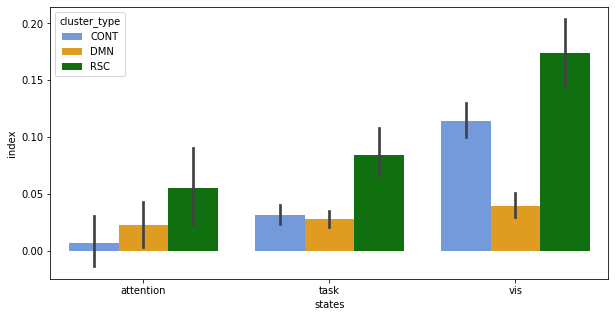

In [31]:
fig = plt.figure(figsize = (10, 5))
sns.barplot(x="states", y="index", hue='cluster_type', 
            palette=["cornflowerblue", "orange", "green"], data=merge_long)
plt.show()

In [35]:
from statsmodels.stats.multitest import fdrcorrection
fdrcorrection([0.5243747390003581, 0.040094052534166515, 0.005791831650857415], alpha=0.05, method='indep', is_sorted=False)

(array([False, False,  True]), array([0.52437474, 0.06014108, 0.01737549]))

## Full PS matrix

In [7]:
def compute_ps(run1, run2):
    """
    run1 and run2 are two lists, each is a list of 4 epochs 
    """
    ps = []
    for epoch in run1:
        ps.append(np.mean([np.arctanh(pearsonr(epoch, y)[0]) for y in run2]))
    ps_mean = np.mean(ps)
    return(ps_mean)
        
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceTask_sceneTask_epoch_lables_48epochs.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# get epoch identity (i.e., face/scene task under which condition )
epoch_identity = pd.read_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/epoch_and_labels/block_image_identity.csv')
faceTask_cond = epoch_identity.loc[epoch_identity['block'] == 'Face', 'condition'].tolist()
sceneTask_cond = epoch_identity.loc[epoch_identity['block'] == 'Scene', 'condition'].tolist()
epoch_dic = {}
for sub in range(num_subjs):
    epoch_start = epochs_per_subj*sub
    epoch_cond_start = int(epochs_per_subj/2*sub)
    epoch = epoch_info[epoch_start: epoch_start + epochs_per_subj]
    sub_faceTask_cond = faceTask_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    sub_sceneTask_cond = sceneTask_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    for e, cond in zip(epoch, sub_faceTask_cond + sub_sceneTask_cond):
        epoch_dic[e] = cond

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
row_ret_FaceTask_roi, row_ret_SceneTask_roi = [], []
row_per_FaceTask_roi, row_per_SceneTask_roi = [], []
row_scramble_FaceTask_roi, row_scramble_SceneTask_roi, = [], []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    row_ret_FaceTask, row_ret_SceneTask = [], []
    row_per_FaceTask, row_per_SceneTask = [], []
    row_scramble_FaceTask, row_scramble_SceneTask, = [], []

    for i in range(24):

        # get all 48 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]
        
        # identity for each block
        cond_identity = list(epoch_dic.values())[start_ind:end_ind]
        face_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(0,24,4))]
        scene_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(24,48,4))]
        
        # face epoch in 6 runs (each run has 4 face epochs)
        face = {}
        for idx, cond in enumerate(face_runs):
            start = 4*idx
            if idx < 3:
                face[f'{cond}_run1_face'] = sub_raw_data_list[start:start+4]
            else:
                face[f'{cond}_run2_face'] = sub_raw_data_list[start:start+4]
        
        # scene epoch in 6 runs (each run has 4 scene epochs)
        scene = {}
        for idx, cond in enumerate(scene_runs):
            start = 24 + 4*idx
            if idx < 3:
                scene[f'{cond}_run1_scene'] = sub_raw_data_list[start:start+4]
            else:
                scene[f'{cond}_run2_scene'] = sub_raw_data_list[start:start+4]
        
        # ----------------------------------------------------------------------------------------------------
        # Build PS matrix for each subject
        # row order: Ret_F_task Ret_S_task; Per_F_task; Per_S_task; Scramble_F_task; Scramble_S_task
        # ----------------------------------------------------------------------------------------------------
        row_ret_FaceTask.append([compute_ps(face['Retrieve_run1_face'], face['Retrieve_run2_face']), # Ret_F_task
                                np.mean([compute_ps(face['Retrieve_run1_face'], scene['Retrieve_run2_scene']), # Ret_S_task
                                         compute_ps(face['Retrieve_run2_face'], scene['Retrieve_run1_scene'])]),  
                                np.mean([compute_ps(face['Retrieve_run1_face'], face['Perceive_run1_face']), # Per_F_task
                                         compute_ps(face['Retrieve_run1_face'], face['Perceive_run2_face']),
                                         compute_ps(face['Retrieve_run2_face'], face['Perceive_run1_face']),
                                         compute_ps(face['Retrieve_run2_face'], face['Perceive_run2_face'])]),
                                np.mean([compute_ps(face['Retrieve_run1_face'], scene['Perceive_run1_scene']), # Per_S_task
                                         compute_ps(face['Retrieve_run1_face'], scene['Perceive_run2_scene']),
                                         compute_ps(face['Retrieve_run2_face'], scene['Perceive_run1_scene']),
                                         compute_ps(face['Retrieve_run2_face'], scene['Perceive_run2_scene'])]),
                                np.mean([compute_ps(face['Retrieve_run1_face'], face['PerceiveScrambled_run1_face']), # Scramble_F_task
                                         compute_ps(face['Retrieve_run1_face'], face['PerceiveScrambled_run2_face']),
                                         compute_ps(face['Retrieve_run2_face'], face['PerceiveScrambled_run1_face']),
                                         compute_ps(face['Retrieve_run2_face'], face['PerceiveScrambled_run2_face'])]), 
                                np.mean([compute_ps(face['Retrieve_run1_face'], scene['PerceiveScrambled_run1_scene']), # Scramble_S_task
                                         compute_ps(face['Retrieve_run1_face'], scene['PerceiveScrambled_run2_scene']),
                                         compute_ps(face['Retrieve_run2_face'], scene['PerceiveScrambled_run1_scene']),
                                         compute_ps(face['Retrieve_run2_face'], scene['PerceiveScrambled_run2_scene'])])]
                                )
        
        row_ret_SceneTask.append([np.mean([compute_ps(scene['Retrieve_run1_scene'], face['Retrieve_run2_face']), # Ret_F_task
                                          compute_ps(scene['Retrieve_run2_scene'], face['Retrieve_run1_face'])]),
                                 compute_ps(scene['Retrieve_run1_scene'], scene['Retrieve_run2_scene']), # Ret_S_task                                       
                                 np.mean([compute_ps(scene['Retrieve_run1_scene'], face['Perceive_run1_face']), # Per_F_task
                                          compute_ps(scene['Retrieve_run1_scene'], face['Perceive_run2_face']),
                                          compute_ps(scene['Retrieve_run2_scene'], face['Perceive_run1_face']),
                                          compute_ps(scene['Retrieve_run2_scene'], face['Perceive_run2_face'])]),
                                 np.mean([compute_ps(scene['Retrieve_run1_scene'], scene['Perceive_run1_scene']), # Per_S_task
                                          compute_ps(scene['Retrieve_run1_scene'], scene['Perceive_run2_scene']),
                                          compute_ps(scene['Retrieve_run2_scene'], scene['Perceive_run1_scene']),
                                          compute_ps(scene['Retrieve_run2_scene'], scene['Perceive_run2_scene'])]),
                                 np.mean([compute_ps(scene['Retrieve_run1_scene'], face['PerceiveScrambled_run1_face']), # Scramble_F_task
                                          compute_ps(scene['Retrieve_run1_scene'], face['PerceiveScrambled_run2_face']),
                                          compute_ps(scene['Retrieve_run2_scene'], face['PerceiveScrambled_run1_face']),
                                          compute_ps(scene['Retrieve_run2_scene'], face['PerceiveScrambled_run2_face'])]), 
                                 np.mean([compute_ps(scene['Retrieve_run1_scene'], scene['PerceiveScrambled_run1_scene']), # Scramble_S_task
                                          compute_ps(scene['Retrieve_run1_scene'], scene['PerceiveScrambled_run2_scene']),
                                          compute_ps(scene['Retrieve_run2_scene'], scene['PerceiveScrambled_run1_scene']),
                                          compute_ps(scene['Retrieve_run2_scene'], scene['PerceiveScrambled_run2_scene'])])]
                                )
        
        row_per_FaceTask.append([np.mean([compute_ps(face['Perceive_run1_face'], face['Retrieve_run1_face']), # Ret_F_task
                                         compute_ps(face['Perceive_run1_face'], face['Retrieve_run2_face']),
                                         compute_ps(face['Perceive_run2_face'], face['Retrieve_run1_face']),
                                         compute_ps(face['Perceive_run2_face'], face['Retrieve_run2_face'])]),
                                np.mean([compute_ps(face['Perceive_run1_face'], scene['Retrieve_run1_scene']), # Ret_S_task
                                         compute_ps(face['Perceive_run1_face'], scene['Retrieve_run2_scene']),
                                         compute_ps(face['Perceive_run2_face'], scene['Retrieve_run1_scene']),
                                         compute_ps(face['Perceive_run2_face'], scene['Retrieve_run2_scene'])]),
                                compute_ps(face['Perceive_run2_face'], face['Perceive_run1_face']), # Per_F_task
                                np.mean([compute_ps(face['Perceive_run1_face'], scene['Perceive_run2_scene']), # Per_S_task
                                         compute_ps(face['Perceive_run2_face'], scene['Perceive_run1_scene'])]),
                                np.mean([compute_ps(face['Perceive_run1_face'], face['PerceiveScrambled_run1_face']), # Scramble_F_task
                                         compute_ps(face['Perceive_run1_face'], face['PerceiveScrambled_run2_face']),
                                         compute_ps(face['Perceive_run2_face'], face['PerceiveScrambled_run1_face']),
                                         compute_ps(face['Perceive_run2_face'], face['PerceiveScrambled_run2_face'])]), 
                                np.mean([compute_ps(face['Perceive_run1_face'], scene['PerceiveScrambled_run1_scene']), # Scramble_S_task
                                         compute_ps(face['Perceive_run1_face'], scene['PerceiveScrambled_run2_scene']),
                                         compute_ps(face['Perceive_run2_face'], scene['PerceiveScrambled_run1_scene']),
                                         compute_ps(face['Perceive_run2_face'], scene['PerceiveScrambled_run2_scene'])])]
                                )
        
        row_per_SceneTask.append([np.mean([compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run1_face']), # Ret_F_task
                                         compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run2_face']),
                                         compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run1_face']),
                                         compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run2_face'])]),
                                np.mean([compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run1_scene']), # Ret_S_task
                                         compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run2_scene']),
                                         compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run1_scene']),
                                         compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run2_scene'])]),
                                np.mean([compute_ps(scene['Perceive_run1_scene'], face['Perceive_run2_face']), # Per_F_task
                                         compute_ps(scene['Perceive_run2_scene'], face['Perceive_run1_face'])]),
                                compute_ps(scene['Perceive_run1_scene'], scene['Perceive_run2_scene']), # Per_S_task
                                np.mean([compute_ps(scene['Perceive_run1_scene'], face['PerceiveScrambled_run1_face']), # Scramble_F_task
                                         compute_ps(scene['Perceive_run1_scene'], face['PerceiveScrambled_run2_face']),
                                         compute_ps(scene['Perceive_run2_scene'], face['PerceiveScrambled_run1_face']),
                                         compute_ps(scene['Perceive_run2_scene'], face['PerceiveScrambled_run2_face'])]), 
                                np.mean([compute_ps(scene['Perceive_run1_scene'], scene['PerceiveScrambled_run1_scene']), # Scramble_S_task
                                         compute_ps(scene['Perceive_run1_scene'], scene['PerceiveScrambled_run2_scene']),
                                         compute_ps(scene['Perceive_run2_scene'], scene['PerceiveScrambled_run1_scene']),
                                         compute_ps(scene['Perceive_run2_scene'], scene['PerceiveScrambled_run2_scene'])])]
                                )
        
        row_scramble_FaceTask.append([np.mean([compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run1_face']), # Ret_F_task
                                              compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run2_face']),
                                              compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run1_face']),
                                              compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run2_face'])]),
                                     np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run1_scene']), # Ret_S_task
                                              compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run2_scene']),
                                              compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run1_scene']),
                                              compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run2_scene'])]),
                                     np.mean([compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run1_face']), # Per_F_task
                                              compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run2_face']),
                                              compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run1_face']),
                                              compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run2_face'])]),
                                     np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run1_scene']), # Per_S_task
                                              compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run2_scene']),
                                              compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run1_scene']),
                                              compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run2_scene'])]),
                                     compute_ps(face['PerceiveScrambled_run1_face'], face['PerceiveScrambled_run2_face']), # Scramble_F_task
                                     np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['PerceiveScrambled_run2_scene']), # Scramble_S_task
                                              compute_ps(face['PerceiveScrambled_run2_face'], scene['PerceiveScrambled_run1_scene'])])]
                                )
        
        row_scramble_SceneTask.append([np.mean([compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run1_face']), # Ret_F_task
                                              compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run2_face']),
                                              compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run1_face']),
                                              compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run2_face'])]),
                                     np.mean([compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run1_scene']), # Ret_S_task
                                              compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run2_scene']),
                                              compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run1_scene']),
                                              compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run2_scene'])]),
                                     np.mean([compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run1_face']), # Per_F_task
                                              compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run2_face']),
                                              compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run1_face']),
                                              compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run2_face'])]),
                                     np.mean([compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run1_scene']), # Per_S_task
                                              compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run2_scene']),
                                              compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run1_scene']),
                                              compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run2_scene'])]),
                                     np.mean([compute_ps(scene['PerceiveScrambled_run1_scene'], face['PerceiveScrambled_run2_face']), # Scramble_F_task
                                              compute_ps(scene['PerceiveScrambled_run2_scene'], face['PerceiveScrambled_run1_face'])]),
                                     compute_ps(scene['PerceiveScrambled_run1_scene'], scene['PerceiveScrambled_run2_scene'])] # Scramble_S_task                                    
                                )
        
    # each ROI
    row_ret_FaceTask_roi.append(row_ret_FaceTask)
    row_ret_SceneTask_roi.append(row_ret_SceneTask)
    row_per_FaceTask_roi.append(row_per_FaceTask)
    row_per_SceneTask_roi.append(row_per_SceneTask)
    row_scramble_FaceTask_roi.append(row_scramble_FaceTask)
    row_scramble_SceneTask_roi.append(row_scramble_SceneTask)

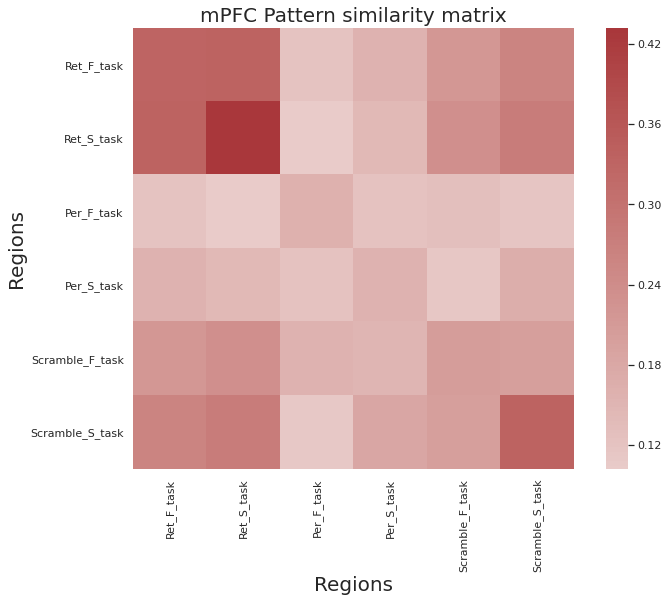

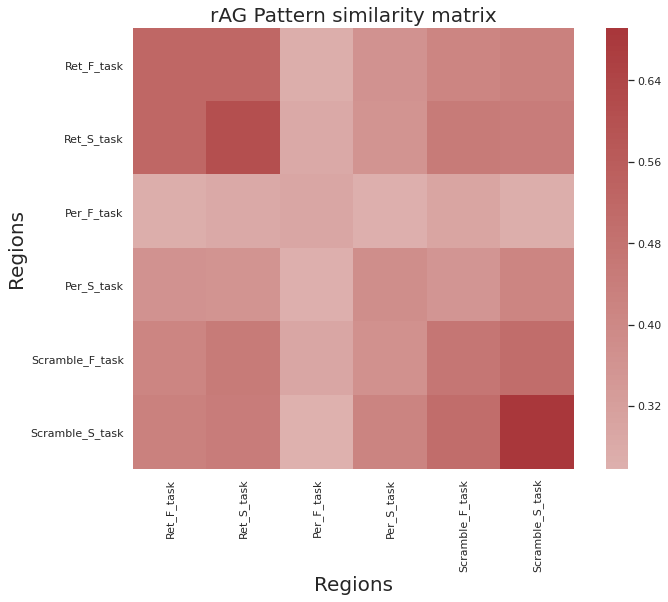

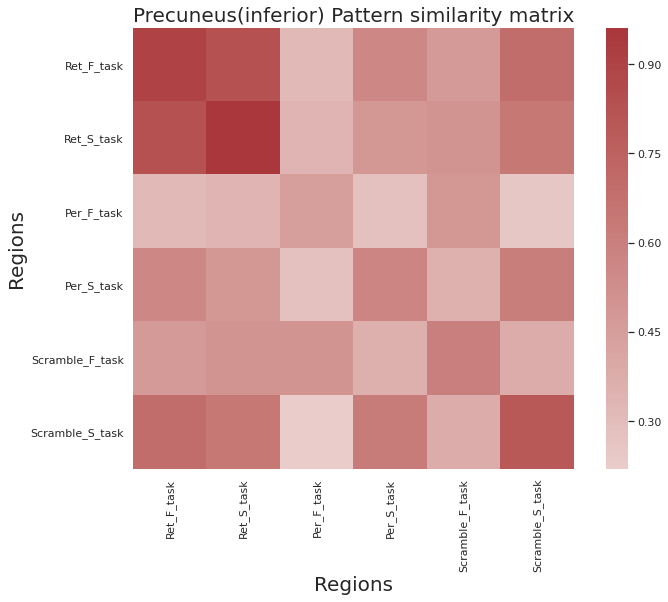

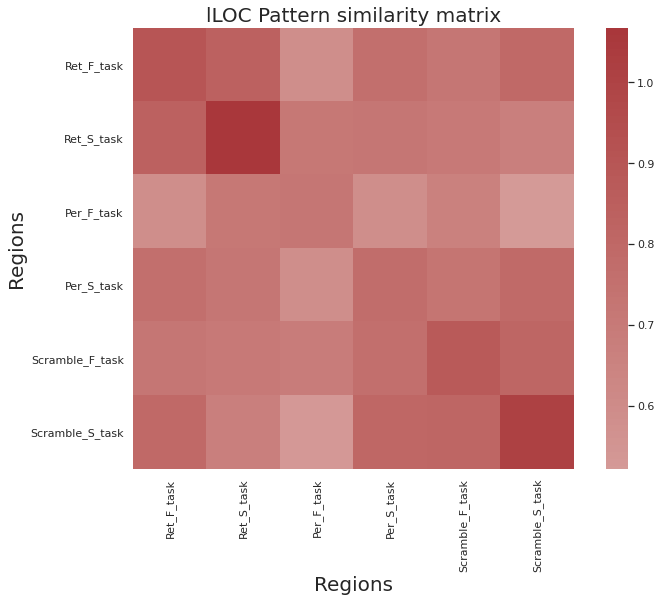

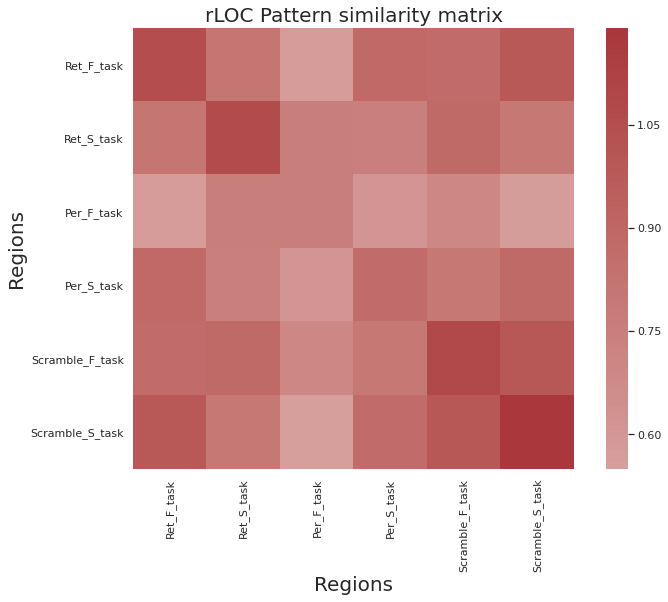

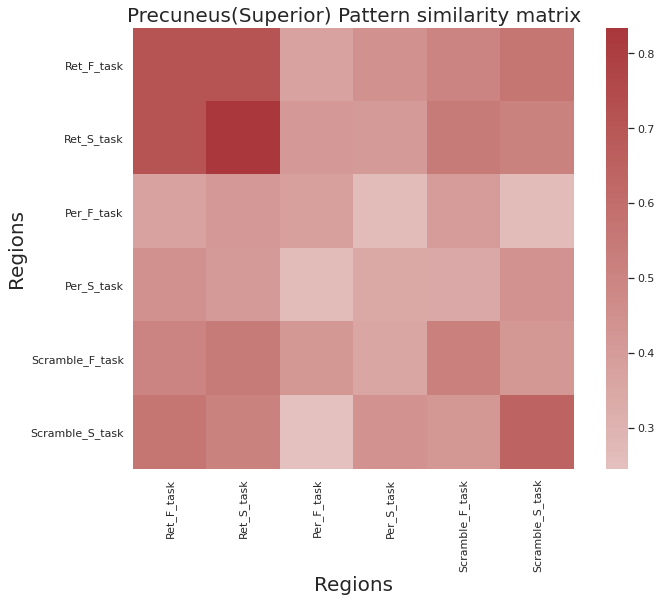

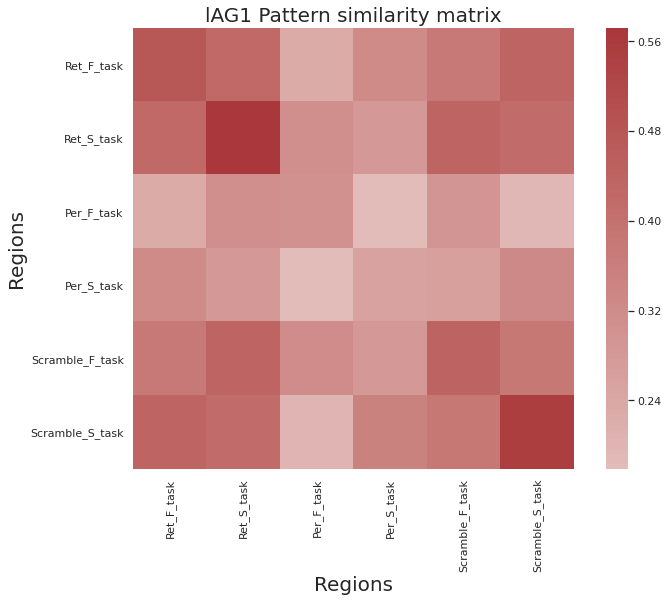

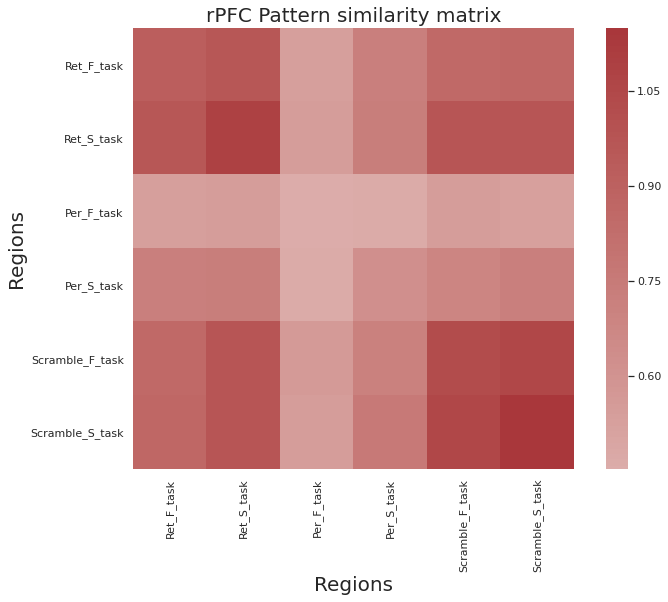

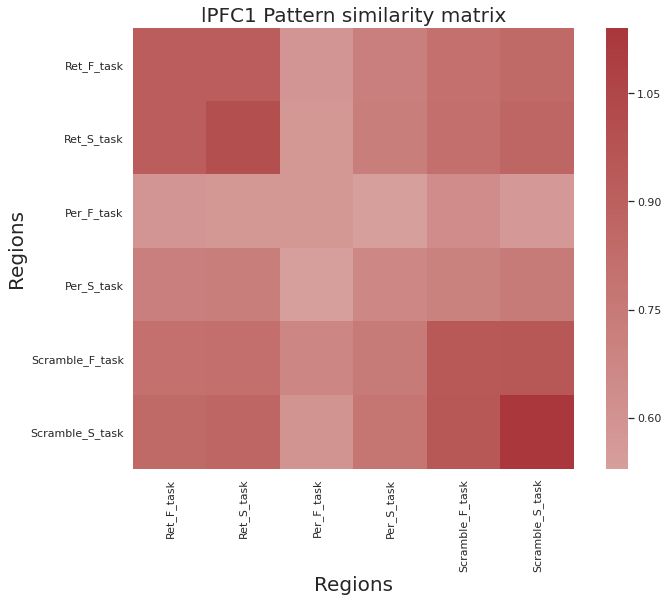

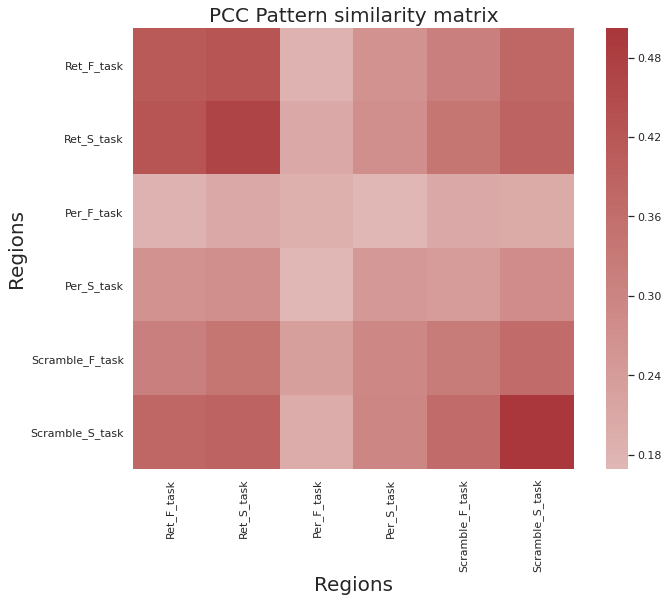

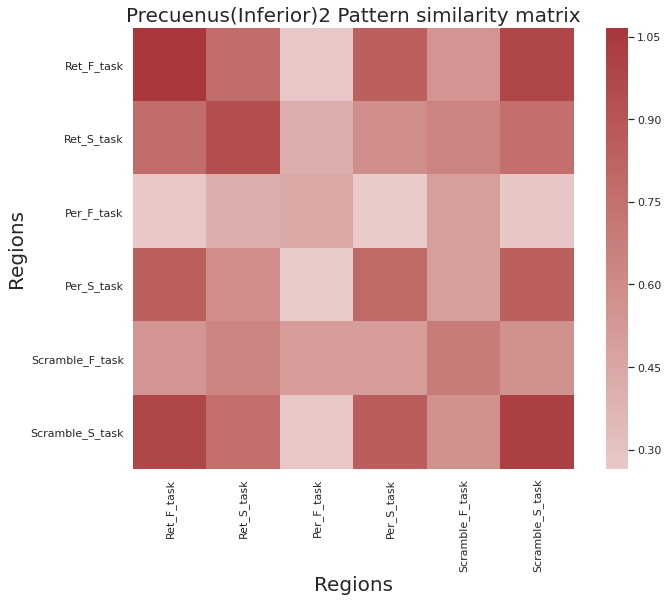

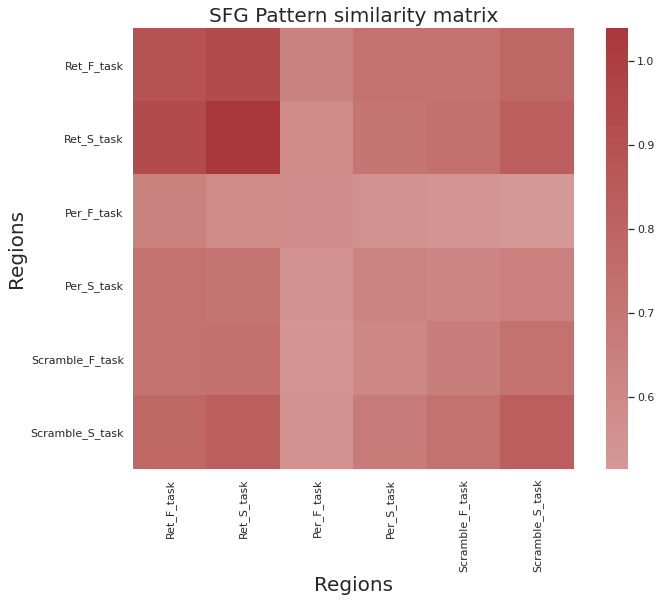

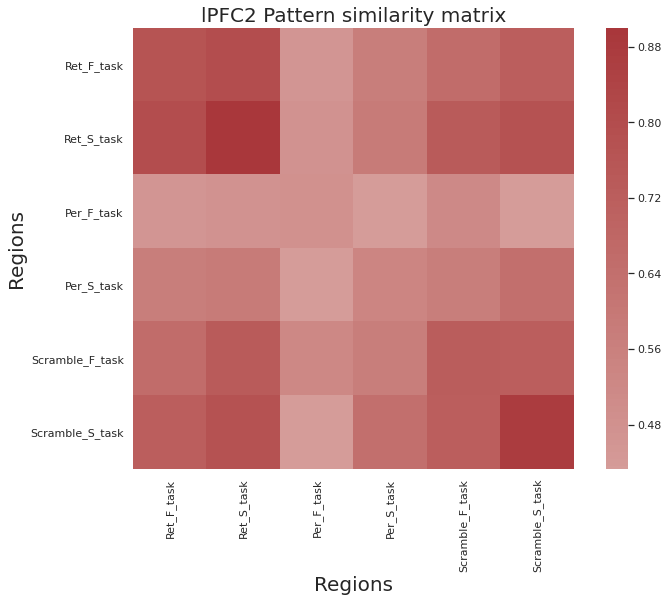

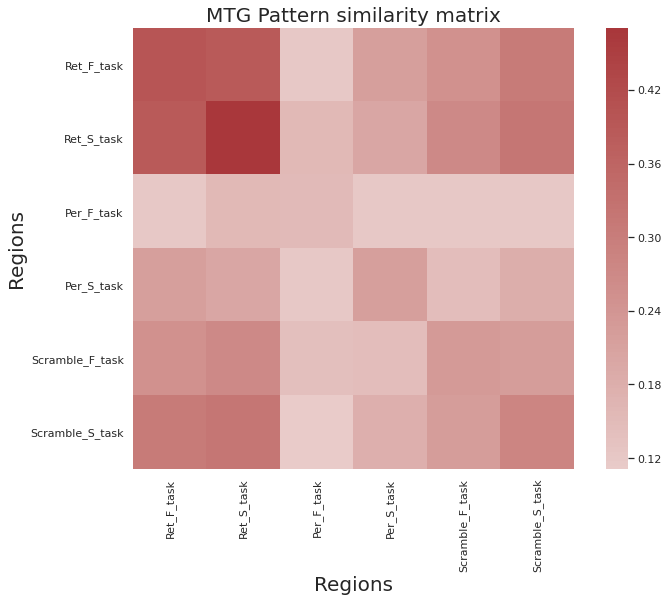

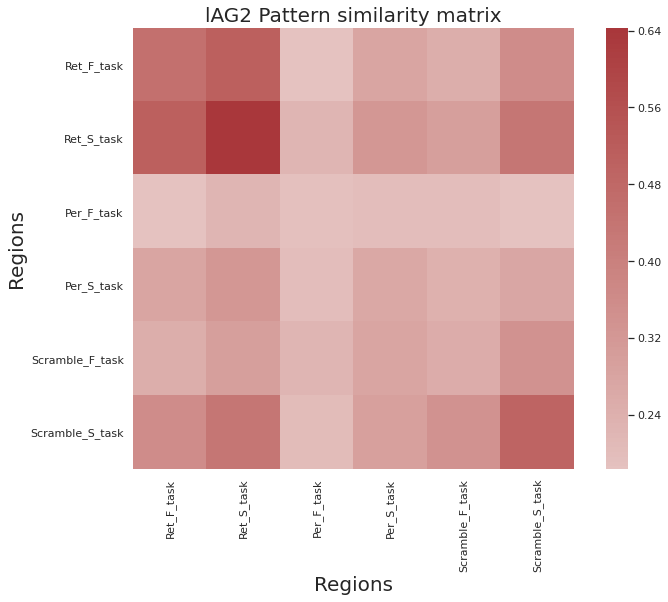

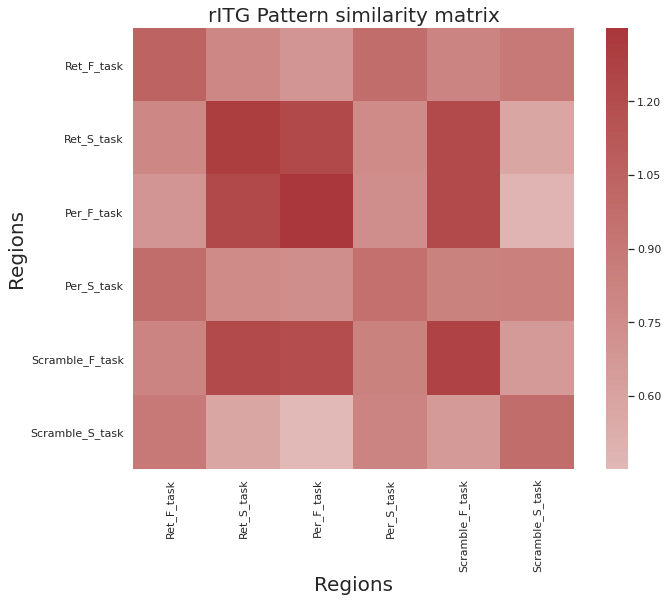

In [11]:
%matplotlib inline
ROI_sub_psMAT = np.stack([np.array(row_ret_FaceTask_roi), np.array(row_ret_SceneTask_roi), 
                          np.array(row_per_FaceTask_roi), np.array(row_per_SceneTask_roi), 
                          np.array(row_scramble_FaceTask_roi), np.array(row_scramble_SceneTask_roi)], axis = 2)
ROI_psMAT = np.mean(ROI_sub_psMAT, axis = 1)
ROI_name = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1",
            "PCC","Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
for idx in range(16):
    #mat = ROI_psMAT[idx, :, :] - np.mean(ROI_psMAT[idx, :, :]) # scale
    sns.set(style="white");
    plt.subplots(figsize=(10,7)); cmap = sns.diverging_palette(220, 10, as_cmap=True);
    axis_labels = ["Ret_F_task", "Ret_S_task", "Per_F_task", "Per_S_task", "Scramble_F_task", "Scramble_S_task"]
    sns.heatmap(ROI_psMAT[idx, :, :], center=0, cmap='vlag', square = True, xticklabels=axis_labels,yticklabels=axis_labels);
    plt.ylabel('Regions',fontsize=20); plt.xlabel('Regions',fontsize=20); plt.title(f"{ROI_name[idx]} Pattern similarity matrix", fontsize=20)
    plt.subplots_adjust(left=None, bottom=None, right=1, top=1, wspace=1, hspace=2);
    plt.show()

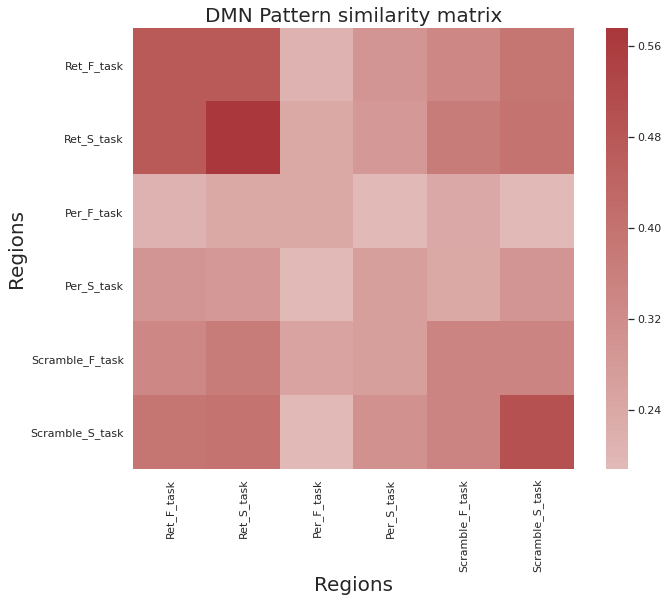

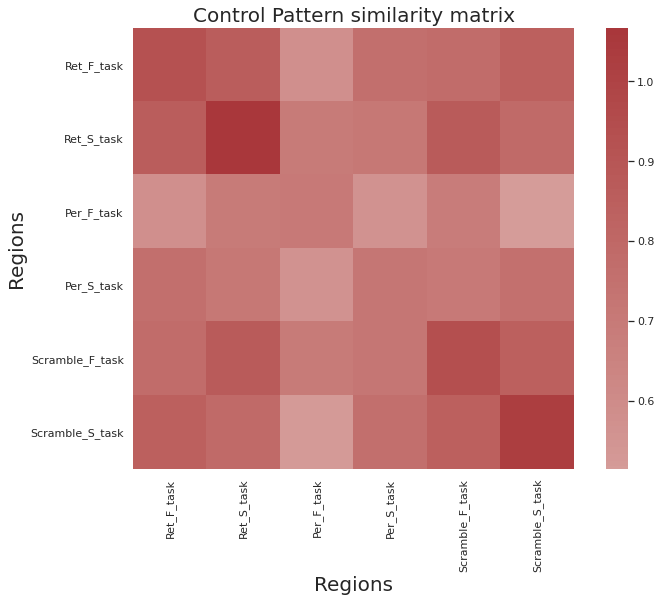

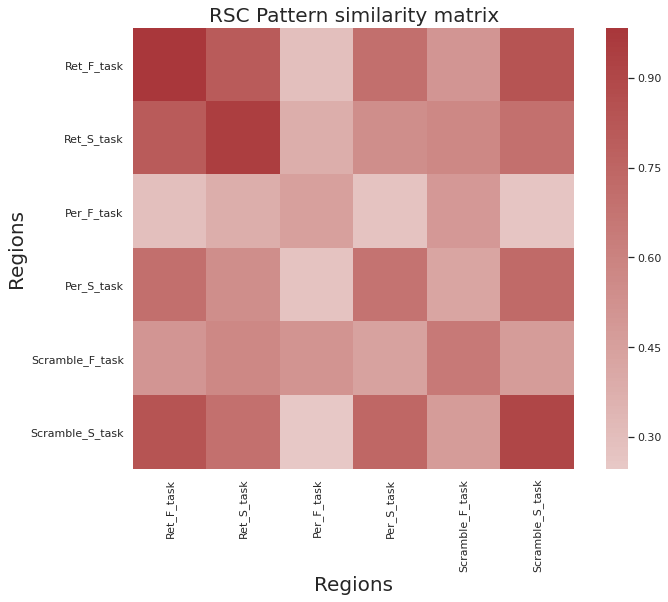

In [21]:
ROI_psMAT = np.mean(ROI_sub_psMAT, axis = 1)
psmat_name = ["DMN", "Control", "RSC"]

dmn_psmat = np.mean(ROI_psMAT[[0,1,5,6,9,13,14],:,:], axis = 0)
cont_psmat = np.mean(ROI_psMAT[[3,4,7,8,11,12,15],:,:], axis = 0)
rsc_psmat = np.mean(ROI_psMAT[[2,10],:,:], axis = 0)


for idx, psmat in enumerate([dmn_psmat, cont_psmat, rsc_psmat]):
    sns.set(style="white");
    plt.subplots(figsize=(10,7)); cmap = sns.diverging_palette(220, 10, as_cmap=True);
    axis_labels = ["Ret_F_task", "Ret_S_task", "Per_F_task", "Per_S_task", "Scramble_F_task", "Scramble_S_task"]
    sns.heatmap(psmat, center=0, cmap='vlag', square = True, xticklabels=axis_labels,yticklabels=axis_labels);
    plt.ylabel('Regions',fontsize=20); plt.xlabel('Regions',fontsize=20); plt.title(f"{psmat_name[idx]} Pattern similarity matrix", fontsize=20)
    plt.subplots_adjust(left=None, bottom=None, right=1, top=1, wspace=1, hspace=2);
    plt.show()

## Check content 

In [346]:
def _compute_ps(epoch1, epoch2):

    ps = np.arctanh(pearsonr(epoch1, epoch2)[0]) 
    
    return(ps)

def _find_counter_partner_and_control(run, cue):
     
    # check if the counter partner exist 
    counter_partner_idx = run[run['associate_id'] == cue].index
    if len(counter_partner_idx) > 0:
        # if there is a counter partner; find the control trials. 
        counter_partner_cue_cat = run.loc[counter_partner_idx[0], 'block'] # the category of the cue image
        output_dic = {}
        same_cue_cat_control_idx = run[run['block'] == counter_partner_cue_cat].index.tolist()
        same_cue_cat_control_idx.remove(counter_partner_idx)
        output_dic['same_cue_cat_control_idx'] = same_cue_cat_control_idx
        output_dic['dif_cue_cat_control_idx'] = run[run['block'] != counter_partner_cue_cat].index.tolist()
        output_dic['counter_partner_idx'] = counter_partner_idx.tolist()
    else: 
        output_dic = np.nan
    
    return output_dic
        
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/allconds_epoch_labels_MVPA.npy' # scramble, retrieve, perceive 
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# get epoch identity (i.e., face/scene task under which condition )
epoch_identity = pd.read_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/epoch_and_labels/block_image_identity.csv')
scramble = epoch_identity[epoch_identity['condition'] == 'PerceiveScrambled']
scramble.loc[:,'cp_idx'] = np.nan
retrieve = epoch_identity[epoch_identity['condition'] == 'Retrieve']
retrieve.loc[:,'cp_idx'] = np.nan
perceive =  epoch_identity[epoch_identity['condition'] == 'Perceive']
perceive.loc[:,'cp_idx'] = np.nan


scramble_new = []
retrieve_new = []
perceive_new = []
for i in range(24):

    # epoch info for each condition, each run
    label_run1_start = int(i*epochs_per_subj/3)
    label_run1_end = int(label_run1_start+8)
    label_run2_end = int(label_run1_end+8)
    scramble_run1_info, scramble_run2_info = scramble[label_run1_start: label_run1_end].reset_index(), scramble[label_run1_end: label_run2_end].reset_index()
    ret_run1_info, ret_run2_info = retrieve[label_run1_start: label_run1_end].reset_index(), retrieve[label_run1_end: label_run2_end].reset_index()
    per_run1_info, per_run2_info = perceive[label_run1_start: label_run1_end].reset_index(), perceive[label_run1_end: label_run2_end].reset_index()
    
    # get cue for each condition each run in a list
    scramble_run1_cue, scramble_run2_cue = scramble_run1_info['cue_id'].tolist(), scramble_run2_info['cue_id'].tolist()
    ret_run1_cue, ret_run2_cue = ret_run1_info['cue_id'].tolist(), ret_run2_info['cue_id'].tolist()
    per_run1_cue, per_run2_cue = per_run1_info['cue_id'].tolist(), per_run2_info['cue_id'].tolist()

    # find cp for each cue for each condition
    scramble_run1_cp = [_find_counter_partner_and_control(scramble_run2_info, this_cue) for this_cue in scramble_run1_cue]
    scramble_run2_cp = [_find_counter_partner_and_control(scramble_run1_info, this_cue) for this_cue in scramble_run2_cue]
    ret_run1_cp = [_find_counter_partner_and_control(ret_run2_info, this_cue) for this_cue in ret_run1_cue]
    ret_run2_cp = [_find_counter_partner_and_control(ret_run1_info, this_cue) for this_cue in ret_run2_cue]
    per_run1_cp = [_find_counter_partner_and_control(per_run2_info, this_cue) for this_cue in per_run1_cue]
    per_run2_cp = [_find_counter_partner_and_control(per_run1_info, this_cue) for this_cue in per_run2_cue]
    
    # log it
    scramble_run1_info.loc[:,'cp_idx'] = scramble_run1_cp
    scramble_run2_info.loc[:,'cp_idx'] = scramble_run2_cp
    ret_run1_info.loc[:,'cp_idx'] = ret_run1_cp
    ret_run2_info.loc[:,'cp_idx'] = ret_run2_cp
    per_run1_info.loc[:,'cp_idx'] = per_run1_cp
    per_run2_info.loc[:,'cp_idx'] = per_run2_cp
    
    scramble_new.append(scramble_run1_info)
    scramble_new.append(scramble_run2_info)
    retrieve_new.append(ret_run1_info)
    retrieve_new.append(ret_run2_info)
    perceive_new.append(per_run1_info)
    perceive_new.append(per_run2_info)

scramble_new = pd.concat(scramble_new).reset_index().drop(['level_0', 'index'], axis = 1)
retrieve_new = pd.concat(retrieve_new).reset_index().drop(['level_0', 'index'], axis = 1)
perceive_new = pd.concat(perceive_new).reset_index().drop(['level_0', 'index'], axis = 1)



cluster_scramble_same_control_ps, cluster_scramble_dif_control_ps, cluster_scramble_cp_ps = [], [], []
cluster_ret_same_control_ps, cluster_ret_dif_control_ps, cluster_ret_cp_ps = [], [], []
cluster_per_same_control_ps, cluster_per_dif_control_ps, cluster_per_cp_ps = [], [], []

for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
        
    

    for i in range(24):    
        
        sub_scramble_same_control_ps, sub_scramble_dif_control_ps, sub_scramble_cp_ps = [], [], []
        sub_ret_same_control_ps, sub_ret_dif_control_ps, sub_ret_cp_ps = [], [], []
        sub_per_same_control_ps, sub_per_dif_control_ps, sub_per_cp_ps = [], [], []
        
        # get all 48 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]

        # neural data for each condition, each run
        scramble_run1_data, scramble_run2_data = sub_raw_data_list[0:8], sub_raw_data_list[8:16]
        ret_run1_data, ret_run2_data = sub_raw_data_list[16:24], sub_raw_data_list[24:32]
        per_run1_data, per_run2_data = sub_raw_data_list[32:40], sub_raw_data_list[40:48]
        
        # epoch info for each condition, each run
        cond_start_idx = int(i*(epochs_per_subj/3))
        cond_end_idx = int(cond_start_idx + 16)
        sub_scramble_info = scramble_new[cond_start_idx:cond_end_idx]
        sub_retrieve_info = retrieve_new[cond_start_idx:cond_end_idx]
        sub_perceive_info = perceive_new[cond_start_idx:cond_end_idx]
        
        scramble_run1_info = sub_scramble_info[0:8].reset_index()
        scramble_run2_info = sub_scramble_info[8:16].reset_index()
        ret_run1_info = sub_retrieve_info[0:8].reset_index()
        ret_run2_info = sub_retrieve_info[8:16].reset_index()
        per_run1_info = sub_perceive_info[0:8].reset_index()
        per_run2_info = sub_perceive_info[8:16].reset_index()
        
        # scramble
        for idx, epoch in enumerate(scramble_run1_data):
            if pd.isna(scramble_run2_info.loc[idx, 'cp_idx']):
                continue
            else: 
                sub_scramble_same_control_ps.append([_compute_ps(epoch, scramble_run2_data[e]) for e in scramble_run2_info.loc[idx, 'cp_idx']['same_cue_cat_control_idx']]) 
                sub_scramble_dif_control_ps.append([_compute_ps(epoch, scramble_run2_data[e]) for e in scramble_run2_info.loc[idx, 'cp_idx']['dif_cue_cat_control_idx']]) 
                sub_scramble_cp_ps.append(_compute_ps(epoch, scramble_run2_data[scramble_run2_info.loc[idx, 'cp_idx']['counter_partner_idx'][0]]))
        for idx, epoch in enumerate(scramble_run2_data):
            if pd.isna(scramble_run1_info.loc[idx, 'cp_idx']):
                continue
            else: 
                sub_scramble_same_control_ps.append([_compute_ps(epoch, scramble_run1_data[e]) for e in scramble_run1_info.loc[idx, 'cp_idx']['same_cue_cat_control_idx']]) 
                sub_scramble_dif_control_ps.append([_compute_ps(epoch, scramble_run1_data[e]) for e in scramble_run1_info.loc[idx, 'cp_idx']['dif_cue_cat_control_idx']]) 
                sub_scramble_cp_ps.append(_compute_ps(epoch, scramble_run1_data[scramble_run1_info.loc[idx, 'cp_idx']['counter_partner_idx'][0]]))
        
        # retrieve
        for idx, epoch in enumerate(ret_run1_data):
            if pd.isna(ret_run2_info.loc[idx, 'cp_idx']):
                continue
            else: 
                sub_ret_same_control_ps.append([_compute_ps(epoch, ret_run2_data[e]) for e in ret_run2_info.loc[idx, 'cp_idx']['same_cue_cat_control_idx']]) 
                sub_ret_dif_control_ps.append([_compute_ps(epoch, ret_run2_data[e]) for e in ret_run2_info.loc[idx, 'cp_idx']['dif_cue_cat_control_idx']]) 
                sub_ret_cp_ps.append(_compute_ps(epoch, ret_run2_data[ret_run2_info.loc[idx, 'cp_idx']['counter_partner_idx'][0]]))
        for idx, epoch in enumerate(ret_run2_data):
            if pd.isna(ret_run1_info.loc[idx, 'cp_idx']):
                continue
            else: 
                sub_ret_same_control_ps.append([_compute_ps(epoch, ret_run1_data[e]) for e in ret_run1_info.loc[idx, 'cp_idx']['same_cue_cat_control_idx']]) 
                sub_ret_dif_control_ps.append([_compute_ps(epoch, ret_run1_data[e]) for e in ret_run1_info.loc[idx, 'cp_idx']['dif_cue_cat_control_idx']]) 
                sub_ret_cp_ps.append(_compute_ps(epoch, ret_run1_data[ret_run1_info.loc[idx, 'cp_idx']['counter_partner_idx'][0]]))
                
        
        # perceive
        for idx, epoch in enumerate(per_run1_data):
            if pd.isna(per_run2_info.loc[idx, 'cp_idx']):
                continue
            else: 
                sub_per_same_control_ps.append([_compute_ps(epoch, per_run2_data[e]) for e in per_run2_info.loc[idx, 'cp_idx']['same_cue_cat_control_idx']]) 
                sub_per_dif_control_ps.append([_compute_ps(epoch, per_run2_data[e]) for e in per_run2_info.loc[idx, 'cp_idx']['dif_cue_cat_control_idx']]) 
                sub_per_cp_ps.append(_compute_ps(epoch, per_run2_data[per_run2_info.loc[idx, 'cp_idx']['counter_partner_idx'][0]]))
                
        for idx, epoch in enumerate(per_run2_data):
            if pd.isna(per_run1_info.loc[idx, 'cp_idx']):
                continue
            else: 
                sub_per_same_control_ps.append([_compute_ps(epoch, per_run1_data[e]) for e in per_run1_info.loc[idx, 'cp_idx']['same_cue_cat_control_idx']]) 
                sub_per_dif_control_ps.append([_compute_ps(epoch, per_run1_data[e]) for e in per_run1_info.loc[idx, 'cp_idx']['dif_cue_cat_control_idx']]) 
                sub_per_cp_ps.append(_compute_ps(epoch, per_run1_data[per_run1_info.loc[idx, 'cp_idx']['counter_partner_idx'][0]]))
                
        
        # 24 (sub) x 16 (clusters) = 384 ps measures
        cluster_scramble_same_control_ps.append(np.mean(sub_scramble_same_control_ps))
        cluster_scramble_dif_control_ps.append(np.mean(sub_scramble_dif_control_ps))
        cluster_scramble_cp_ps.append(np.mean(sub_scramble_cp_ps))
        cluster_ret_same_control_ps.append(np.mean(sub_ret_same_control_ps))
        cluster_ret_dif_control_ps.append(np.mean(sub_ret_dif_control_ps))
        cluster_ret_cp_ps.append(np.mean(sub_ret_cp_ps))
        cluster_per_same_control_ps.append(np.mean(sub_per_same_control_ps))
        cluster_per_dif_control_ps.append(np.mean(sub_per_dif_control_ps))
        cluster_per_cp_ps.append(np.mean(sub_per_cp_ps))
        

In [347]:
# a list (cluster) of list (subjects)
cluster_scramble_same_control_ps_list = [cluster_scramble_same_control_ps[start: start+24] for start in list(range(0,384,24))]
cluster_scramble_dif_control_ps_list = [cluster_scramble_dif_control_ps[start: start+24] for start in list(range(0,384,24))]
cluster_scramble_cp_ps_list = [cluster_scramble_cp_ps[start: start+24] for start in list(range(0,384,24))]
cluster_ret_same_control_ps_list = [cluster_ret_same_control_ps[start: start+24] for start in list(range(0,384,24))]
cluster_ret_dif_control_ps_list = [cluster_ret_dif_control_ps[start: start+24] for start in list(range(0,384,24))]
cluster_ret_cp_ps_list = [cluster_ret_cp_ps[start: start+24] for start in list(range(0,384,24))]
cluster_per_same_control_ps_list = [cluster_per_same_control_ps[start: start+24] for start in list(range(0,384,24))]
cluster_per_dif_control_ps_list = [cluster_per_dif_control_ps[start: start+24] for start in list(range(0,384,24))]
cluster_per_cp_ps_list = [cluster_per_cp_ps[start: start+24] for start in list(range(0,384,24))]

In [348]:
%matplotlib inline
default = [0,1,5,6,9,13,14]
control = [3,4,7,8,11,12,15]
rsc = [2,10]

# scramble
cluster_scramble_same_control_ps_default = np.mean(np.array([cluster_scramble_same_control_ps_list[d] for d in default]), axis = 0)
cluster_scramble_same_control_ps_control = np.mean(np.array([cluster_scramble_same_control_ps_list[c] for c in control]), axis = 0)
cluster_scramble_same_control_ps_rsc = np.mean(np.array([cluster_scramble_same_control_ps_list[r] for r in rsc]), axis = 0)

cluster_scramble_dif_control_ps_default = np.mean(np.array([cluster_scramble_dif_control_ps_list[d] for d in default]), axis = 0)
cluster_scramble_dif_control_ps_control = np.mean(np.array([cluster_scramble_dif_control_ps_list[c] for c in control]), axis = 0)
cluster_scramble_dif_control_ps_rsc = np.mean(np.array([cluster_scramble_dif_control_ps_list[r] for r in rsc]), axis = 0)

cluster_scramble_cp_ps_default = np.mean(np.array([cluster_scramble_cp_ps_list[d] for d in default]), axis = 0)
cluster_scramble_cp_ps_control = np.mean(np.array([cluster_scramble_cp_ps_list[c] for c in control]), axis = 0)
cluster_scramble_cp_ps_rsc = np.mean(np.array([cluster_scramble_cp_ps_list[r] for r in rsc]), axis = 0)

In [349]:
# perceive
cluster_per_same_control_ps_default = np.mean(np.array([cluster_per_same_control_ps_list[d] for d in default]), axis = 0)
cluster_per_same_control_ps_control = np.mean(np.array([cluster_per_same_control_ps_list[c] for c in control]), axis = 0)
cluster_per_same_control_ps_rsc = np.mean(np.array([cluster_per_same_control_ps_list[r] for r in rsc]), axis = 0)

cluster_per_dif_control_ps_default = np.mean(np.array([cluster_per_dif_control_ps_list[d] for d in default]), axis = 0)
cluster_per_dif_control_ps_control = np.mean(np.array([cluster_per_dif_control_ps_list[c] for c in control]), axis = 0)
cluster_per_dif_control_ps_rsc = np.mean(np.array([cluster_per_dif_control_ps_list[r] for r in rsc]), axis = 0)

cluster_per_cp_ps_default = np.mean(np.array([cluster_per_cp_ps_list[d] for d in default]), axis = 0)
cluster_per_cp_ps_control = np.mean(np.array([cluster_per_cp_ps_list[c] for c in control]), axis = 0)
cluster_per_cp_ps_rsc = np.mean(np.array([cluster_per_cp_ps_list[r] for r in rsc]), axis = 0)

In [350]:
# retrieve
cluster_ret_same_control_ps_default = np.mean(np.array([cluster_ret_same_control_ps_list[d] for d in default]), axis = 0)
cluster_ret_same_control_ps_control = np.mean(np.array([cluster_ret_same_control_ps_list[c] for c in control]), axis = 0)
cluster_ret_same_control_ps_rsc = np.mean(np.array([cluster_ret_same_control_ps_list[r] for r in rsc]), axis = 0)

cluster_ret_dif_control_ps_default = np.mean(np.array([cluster_ret_dif_control_ps_list[d] for d in default]), axis = 0)
cluster_ret_dif_control_ps_control = np.mean(np.array([cluster_ret_dif_control_ps_list[c] for c in control]), axis = 0)
cluster_ret_dif_control_ps_rsc = np.mean(np.array([cluster_ret_dif_control_ps_list[r] for r in rsc]), axis = 0)

cluster_ret_cp_ps_default = np.mean(np.array([cluster_ret_cp_ps_list[d] for d in default]), axis = 0)
cluster_ret_cp_ps_control = np.mean(np.array([cluster_ret_cp_ps_list[c] for c in control]), axis = 0)
cluster_ret_cp_ps_rsc = np.mean(np.array([cluster_ret_cp_ps_list[r] for r in rsc]), axis = 0)

In [366]:
cluster_ret_same_control_ps_control

array([1.04436721, 0.70131344, 0.87893723, 0.82394216, 0.90349339,
       0.92697484, 0.59044871, 0.86552434, 0.79662692, 0.89841844,
       0.65407794, 0.94612196, 0.88200862, 1.00023045, 0.9681832 ,
       0.67113798, 0.76850505, 0.96436385, 0.80269173, 0.79785433,
       1.12824072, 0.93553778, 1.22624761, 0.73066025])

In [362]:
cluster_ret_same_control_ps_rsc

array([1.07798469, 0.69820983, 1.16705718, 0.81734562, 0.95656577,
       0.8521166 , 0.82418469, 0.60973133, 0.78919547, 0.84470482,
       0.53216296, 0.97186403, 0.77029976, 0.99661895, 1.00453684,
       0.41891323, 0.77532494, 0.41976455, 0.63956107, 0.49506891,
       0.9032104 , 0.72789291, 1.1146717 , 0.89830406])

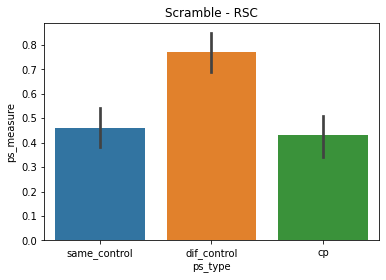

In [351]:
def create_df_and_plot(same_control, dif_control, cp, title):
    
    df = pd.DataFrame({'ps_type' : list(itertools.chain(*[np.repeat('same_control', 24).tolist(), np.repeat('dif_control', 24).tolist(), np.repeat('cp', 24).tolist()])),
                       'ps_measure' : list(same_control) + list(dif_control) + list(cp)})
    
    sns.barplot(x='ps_type', y='ps_measure', data = df).set_title(f'{title}')

# rsc scramble
create_df_and_plot(cluster_scramble_same_control_ps_rsc, cluster_scramble_dif_control_ps_rsc, cluster_scramble_cp_ps_rsc, 'Scramble - RSC') 

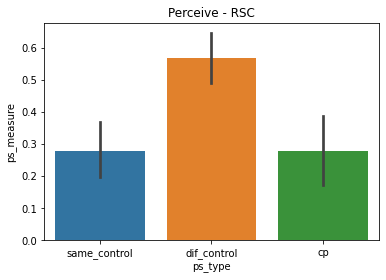

In [352]:
# rsc perceive
create_df_and_plot(cluster_per_same_control_ps_rsc, cluster_per_dif_control_ps_rsc, cluster_per_cp_ps_rsc, 'Perceive - RSC') 

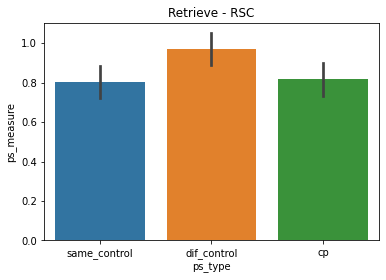

In [353]:
# rsc retrieve
create_df_and_plot(cluster_ret_same_control_ps_rsc, cluster_ret_dif_control_ps_rsc, cluster_ret_cp_ps_rsc, 'Retrieve - RSC') 

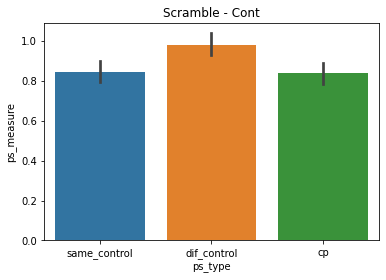

In [360]:
create_df_and_plot(cluster_scramble_same_control_ps_control, cluster_scramble_dif_control_ps_control, cluster_scramble_cp_ps_control, 'Scramble - Cont') 

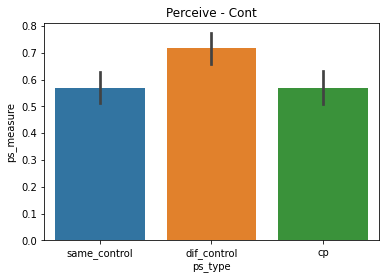

In [355]:
create_df_and_plot(cluster_per_same_control_ps_control, cluster_per_dif_control_ps_control, cluster_per_cp_ps_control, 'Perceive - Cont') 

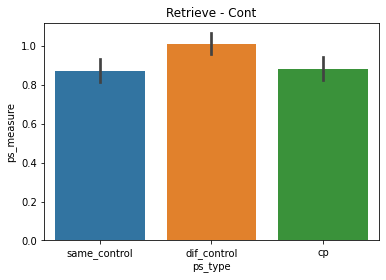

In [356]:
create_df_and_plot(cluster_ret_same_control_ps_control, cluster_ret_dif_control_ps_control, cluster_ret_cp_ps_control, 'Retrieve - Cont' ) 

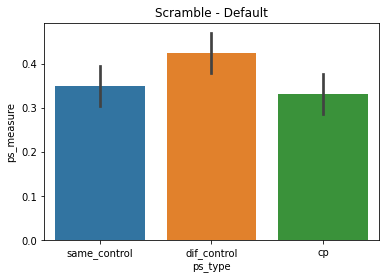

In [357]:
create_df_and_plot(cluster_scramble_same_control_ps_default, cluster_scramble_dif_control_ps_default, cluster_scramble_cp_ps_default,  'Scramble - Default') 

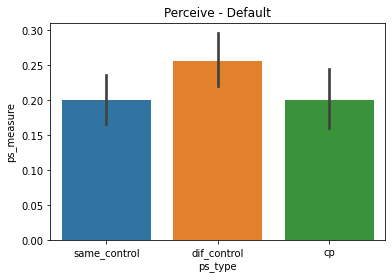

In [358]:
create_df_and_plot(cluster_per_same_control_ps_default, cluster_per_dif_control_ps_default, cluster_per_cp_ps_default,  'Perceive - Default')

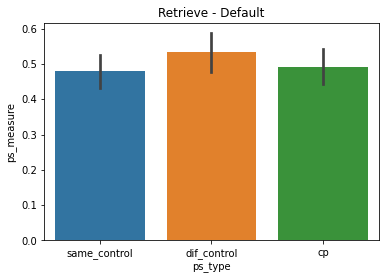

In [359]:
create_df_and_plot(cluster_ret_same_control_ps_default, cluster_ret_dif_control_ps_default, cluster_ret_cp_ps_default,  'Retrieve - Default')